<a href="https://colab.research.google.com/github/daniel-muthukrishna/transomaly/blob/master/compare_methods_bazin_mock_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
! pip install astrorapid
! pip install emcee
! pip install corner
# ! pip install celerite
# ! pip install keras-tcn
# ! pip install tensorflow-gpu

     |████████████████████████████████| 8.3MB 5.7MB/s 
     |████████████████████████████████| 153kB 83.8MB/s 
  Created wheel for extinction: filename=extinction-0.4.0-cp36-cp36m-linux_x86_64.whl size=328508 sha256=ef851b6f5b8f437b295e8ee1f2876c96faa2e959ab95b86e0783d3650ea096e4
  Stored in directory: /root/.cache/pip/wheels/f3/b4/65/aac6a9be9d670e4da20675b82671fb1475044408ebcdecfc9b
Successfully built extinction
     |████████████████████████████████| 51kB 3.6MB/s 


In [3]:
% cd /content/gdrive/My Drive/Projects/transomaly

/content/gdrive/My Drive/Projects/transomaly


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.optimize
import tensorflow as tf
import tensorflow_probability as tfp
import autograd
import numpy.linalg as lin
import pickle
import transomaly
from transomaly import helpers



COLPB = {'g': 'tab:blue', 'r': 'tab:red'} 

In [5]:
# GET BAZIN FIT PARAMETERS FROM PLASTICC DATA
import os
import astrorapid
from astrorapid.get_training_data import get_data

light_curves_sims = {}

for class_num in [1, 2, 3, 51, 60, 64, 61, 62, 63, 90, 92]:
    print("Getting light curves for class", class_num)
    light_curves_sims[class_num] = get_data(get_data_func=astrorapid.get_training_data.get_data_from_snana_fits,
                            class_num=class_num, 
                            data_dir=os.path.join('data/ZTF_20190512'),
                            save_dir=os.path.join('data/saved_light_curves'), 
                            passbands=('g', 'r'), 
                            known_redshift=False,
                            nprocesses=1, 
                            redo=False, 
                            calculate_t0=False)
# light_curves = get_data(get_data_func=astrorapid.get_training_data.get_real_ztf_training_data,
#                         class_num='Ia', 
#                         data_dir=os.path.join('data/real_ZTF_data_from_osc'),
#                         save_dir=os.path.join('data/saved_real_ZTF_light_curves'), 
#                         passbands=('g', 'r'), 
#                         known_redshift=False,
#                         nprocesses=1, 
#                         redo=False, 
#                         calculate_t0=False)



Getting light curves for class 1
Getting light curves for class 2
Getting light curves for class 3
Getting light curves for class 51
Getting light curves for class 60
Getting light curves for class 64
Getting light curves for class 61
Getting light curves for class 62
Getting light curves for class 63
Getting light curves for class 90
Getting light curves for class 92


In [6]:
# Make mock bazin model dataset and Bayesian functions

def get_y_data(fit_until=80, sigma_intrinsic=5, A=100, B=0, t0=10, tau_fall=20, tau_rise=-6, seed=None, t_all=np.arange(-70,80,step=3)):
    np.random.seed(seed)
    epsilon_intrinsic = np.random.normal(0, sigma_intrinsic, size=50)

    sigma_measurement = 20
    yerr_all = np.random.normal(0, sigma_measurement, size=50)

    numerator = np.exp(-(t_all - t0)/tau_fall)
    denominator = 1 + np.exp((t_all-t0)/tau_rise)
    y_all = A * numerator/denominator + B + A*epsilon_intrinsic + yerr_all

    # Only fit up to day `fit_until`
    mask = t_all <= fit_until
    t = t_all[mask]
    y = y_all[mask]
    yerr = yerr_all[mask]
    
    return t, y, yerr, t_all, y_all, yerr_all


def get_y_pred(fit_until=80, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np, t_all=np.arange(-70,80,step=3)):
    A = 10**logA  # np.exp(logA)

    numerator = np.exp(-(t_all - t0)/tau_fall)
    denominator = 1 + np.exp((t_all-t0)/tau_rise)
    y_all = A * numerator/denominator + B
    # Only fit up to day `fit_until`
    mask = t_all <= fit_until
    t = t_all[mask]
    y_pred = y_all[mask]

    return t, y_pred
    
  
def log_likelihood(t_data, y_data, sigma_measurement, fit_until=80, log_sigma_intrinsic=0.7, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np):
    A = 10**logA  # np.exp(logA)
    sigma_intrinsic = 10**log_sigma_intrinsic

    t, y_pred = get_y_pred(fit_until, logA, B, t0, tau_fall, tau_rise, np, t_all=t_data)

    # logL = np.sum(-0.5*np.log(2*np.pi*sigma_intrinsic**2) - 0.5*((y_data - y_pred)**2)/sigma_intrinsic**2)

    mse = -0.5 * (y_data - y_pred)**2 / (A**2*sigma_intrinsic**2 + sigma_measurement**2)
    sigma_trace = -0.5 * np.log(A**2*sigma_intrinsic**2 + sigma_measurement**2)
    log2pi = -0.5 * np.log(2 * np.pi)
    logL = np.sum(mse + sigma_trace + log2pi)
    if np.isnan(logL):
        # print(logL, sigma_intrinsic, A, B, t0, tau_fall, tau_rise)
        # print(y_pred, y_data)
        logL = -np.inf
    return logL
  

def log_prior(class_num, passband, log_sigma_intrinsic=0.7, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np):
    x = np.array([log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise])
 
    if class_num == 1:
        if passband == 'g':
            means = np.array([-10.18097659,   2.92504036,  -2.21199637,  -0.67569   ,
            12.73438492,  -3.41687951])
            covariance = np.array([[ 3.05666754e+02,  2.11527445e-01, -1.19573107e+01,
            -5.09196537e+00, -1.44343953e+00, -4.44457371e-02],
          [ 2.11527445e-01,  1.06291153e-01, -8.42062206e-01,
            8.53258913e-01,  1.60241681e-01,  3.68228389e-02],
          [-1.19573107e+01, -8.42062206e-01,  2.00847577e+02,
            -1.94512588e+01, -1.60153770e+01,  4.22009171e+00],
          [-5.09196537e+00,  8.53258913e-01, -1.94512588e+01,
            2.93785726e+01, -4.56492757e+00, -1.54782023e+00],
          [-1.44343953e+00,  1.60241681e-01, -1.60153770e+01,
            -4.56492757e+00,  1.99886112e+01,  1.92999633e-01],
          [-4.44457371e-02,  3.68228389e-02,  4.22009171e+00,
            -1.54782023e+00,  1.92999633e-01,  1.09341053e+00]])
            inverse_covariance = np.array([[ 3.32790175e-03, -1.87376304e-02,  3.16712323e-04,
            1.56778089e-03,  9.86990127e-04,  1.58904907e-03],
          [-1.87376304e-02,  1.43995450e+01,  2.01633242e-02,
            -5.05291731e-01, -2.04030832e-01, -1.24278929e+00],
          [ 3.16712323e-04,  2.01633242e-02,  6.33844234e-03,
            3.46787053e-03,  5.93708693e-03, -2.12686974e-02],
          [ 1.56778089e-03, -5.05291731e-01,  3.46787053e-03,
            5.87103635e-02,  1.95457294e-02,  8.33556954e-02],
          [ 9.86990127e-04, -2.04030832e-01,  5.93708693e-03,
            1.95457294e-02,  6.09473700e-02,  9.07496250e-04],
          [ 1.58904907e-03, -1.24278929e+00, -2.12686974e-02,
            8.33556954e-02,  9.07496250e-04,  1.15641285e+00]])
    if class_num == 1:
        if passband == 'r':
            means = np.array([-11.58109407,   2.89569173,  -0.12289481,  -2.11271873,
            22.4920898 ,  -3.94124942])
            covariance = np.array([[ 4.18807667e+02,  3.16901877e-02, -4.62753708e+01,
            -1.85339484e+00,  3.15573541e+00, -1.14662102e+00],
          [ 3.16901877e-02,  6.51689569e-02, -5.58363612e-01,
            7.15796249e-01,  2.44992596e-01,  4.57019002e-02],
          [-4.62753708e+01, -5.58363612e-01,  1.65385085e+02,
            -1.79594837e+01, -1.86803328e+01,  2.99632193e+00],
          [-1.85339484e+00,  7.15796249e-01, -1.79594837e+01,
            3.32739731e+01, -4.30329607e+00, -1.86947226e+00],
          [ 3.15573541e+00,  2.44992596e-01, -1.86803328e+01,
            -4.30329607e+00,  3.64224079e+01,  2.55123047e+00],
          [-1.14662102e+00,  4.57019002e-02,  2.99632193e+00,
            -1.86947226e+00,  2.55123047e+00,  1.43397477e+00]])
            inverse_covariance = np.array([[ 2.47690485e-03, -4.27188723e-03,  7.62414503e-04,
            7.30619584e-04,  2.14857565e-04,  1.09387358e-03],
          [-4.27188723e-03,  2.33056527e+01,  2.58120483e-02,
            -5.78427562e-01, -1.17240702e-01, -1.34562918e+00],
          [ 7.62414503e-04,  2.58120483e-02,  7.73218927e-03,
            3.13697804e-03,  5.66245122e-03, -2.23541674e-02],
          [ 7.30619584e-04, -5.78427562e-01,  3.13697804e-03,
            4.86946253e-02,  6.70543767e-03,  6.40176680e-02],
          [ 2.14857565e-04, -1.17240702e-01,  5.66245122e-03,
            6.70543767e-03,  3.64010079e-02, -6.39437850e-02],
          [ 1.09387358e-03, -1.34562918e+00, -2.23541674e-02,
            6.40176680e-02, -6.39437850e-02,  9.85057037e-01]])
    if class_num == 2:
        if passband == 'g':
            means = np.array([-9.88991572,  2.83641739, -0.31249515, -5.04658615, 22.51376967,
          -2.39059956])
            covariance = np.array([[ 3.85724506e+02,  2.15291947e-01, -4.79508716e+01,
            6.81824257e-01,  8.24827831e+00,  2.84937176e-01],
          [ 2.15291947e-01,  7.50398636e-02, -1.97217381e-01,
            7.55089281e-01, -6.04509971e-02,  3.27314509e-02],
          [-4.79508716e+01, -1.97217381e-01,  6.08481049e+01,
            -4.91444285e+00, -5.88139941e+00,  8.28978735e-01],
          [ 6.81824257e-01,  7.55089281e-01, -4.91444285e+00,
            3.66992227e+01, -1.01861687e+01, -8.55031031e-01],
          [ 8.24827831e+00, -6.04509971e-02, -5.88139941e+00,
            -1.01861687e+01,  1.14313731e+02,  2.00579699e+00],
          [ 2.84937176e-01,  3.27314509e-02,  8.28978735e-01,
            -8.55031031e-01,  2.00579699e+00,  1.69566420e+00]])
            inverse_covariance = np.array([[ 2.88172269e-03, -4.83236552e-03,  2.29413308e-03,
            3.11059193e-04, -4.18162668e-05, -1.30620610e-03],
          [-4.83236552e-03,  1.73384104e+01,  2.84605648e-02,
            -3.68457792e-01, -1.27527057e-02, -5.18493649e-01],
          [ 2.29413308e-03,  2.84605648e-02,  1.87495289e-02,
            1.96364357e-03,  1.17336856e-03, -1.04989910e-02],
          [ 3.11059193e-04, -3.68457792e-01,  1.96364357e-03,
            3.63435168e-02,  2.75070539e-03,  2.11723436e-02],
          [-4.18162668e-05, -1.27527057e-02,  1.17336856e-03,
            2.75070539e-03,  9.22230563e-03, -9.84245728e-03],
          [-1.30620610e-03, -5.18493649e-01, -1.04989910e-02,
            2.11723436e-02, -9.84245728e-03,  6.27418836e-01]])
    if class_num == 2:
        if passband == 'r':
            means = np.array([-8.46830672,  2.76027056, -1.48049536, -4.68258291, 52.51620724,
          -3.40306877])
            covariance = np.array([[ 1.91103803e+02,  4.96082476e-02, -1.96171281e+01,
            6.58129083e-01,  2.77316133e-01, -1.56541989e+00],
          [ 4.96082476e-02,  8.13318660e-02, -8.76465515e-01,
            8.83743797e-01, -2.29580182e+00,  3.09976477e-01],
          [-1.96171281e+01, -8.76465515e-01,  2.31150521e+02,
            -1.79005879e+01,  8.46851553e+00, -9.31752717e+00],
          [ 6.58129083e-01,  8.83743797e-01, -1.79005879e+01,
            4.45911105e+01, -5.95476475e+01, -2.23562942e+00],
          [ 2.77316133e-01, -2.29580182e+00,  8.46851553e+00,
            -5.95476475e+01,  2.48318699e+03,  1.37616875e+00],
          [-1.56541989e+00,  3.09976477e-01, -9.31752717e+00,
            -2.23562942e+00,  1.37616875e+00,  1.83565800e+01]])
            inverse_covariance = np.array([[ 5.28903938e-03, -3.41776087e-03,  4.84698952e-04,
            2.22795039e-04, -4.94161320e-07,  7.81951527e-04],
          [-3.41776087e-03,  1.78763457e+01,  2.67851606e-02,
            -3.49099912e-01,  8.24869726e-03, -3.31697684e-01],
          [ 4.84698952e-04,  2.67851606e-02,  4.66983632e-03,
            1.50214260e-03,  4.36204755e-05,  2.13904331e-03],
          [ 2.22795039e-04, -3.49099912e-01,  1.50214260e-03,
            3.10146491e-02,  4.10061211e-04,  1.04230054e-02],
          [-4.94161320e-07,  8.24869726e-03,  4.36204755e-05,
            4.10061211e-04,  4.20073955e-04, -9.87432552e-05],
          [ 7.81951527e-04, -3.31697684e-01,  2.13904331e-03,
            1.04230054e-02, -9.87432552e-05,  6.25067971e-02]])
    if class_num == 3:
        if passband == 'g':
            means = np.array([-10.18427914,   2.792286  ,   0.47702025,  -3.72591354,
            15.2837809 ,  -3.00479932])
            covariance = np.array([[ 3.10840012e+02,  3.17985842e-01,  7.54306937e+01,
            1.74068033e+00, -2.16771036e+01,  2.88678803e+00],
          [ 3.17985842e-01,  9.75398081e-02,  8.68889683e-01,
            1.08233544e+00, -8.80358039e-02,  6.82183780e-03],
          [ 7.54306937e+01,  8.68889683e-01,  2.59489384e+02,
            2.23442935e+01, -5.69315441e+01,  8.69842356e+00],
          [ 1.74068033e+00,  1.08233544e+00,  2.23442935e+01,
            5.16339833e+01, -2.53671828e+01, -1.58258832e+00],
          [-2.16771036e+01, -8.80358039e-02, -5.69315441e+01,
            -2.53671828e+01,  7.29335630e+01, -2.07657970e+00],
          [ 2.88678803e+00,  6.82183780e-03,  8.69842356e+00,
            -1.58258832e+00, -2.07657970e+00,  2.05566578e+00]])
            inverse_covariance = np.array([[ 3.48796393e-03, -1.18878307e-02, -9.24616877e-04,
            8.35736960e-04,  5.99892703e-04,  3.03135900e-04],
          [-1.18878307e-02,  1.46900369e+01, -3.62255889e-02,
            -3.77896426e-01, -1.54799912e-01, -3.26073780e-01],
          [-9.24616877e-04, -3.62255889e-02,  5.69563186e-03,
            -6.39548011e-04,  3.34127238e-03, -1.97991539e-02],
          [ 8.35736960e-04, -3.77896426e-01, -6.39548011e-04,
            3.50889955e-02,  1.27114936e-02,  4.26413074e-02],
          [ 5.99892703e-04, -1.54799912e-01,  3.34127238e-03,
            1.27114936e-02,  2.12086685e-02,  1.67434836e-02],
          [ 3.03135900e-04, -3.26073780e-01, -1.97991539e-02,
            4.26413074e-02,  1.67434836e-02,  6.20637648e-01]])
    if class_num == 3:
        if passband == 'r':
            means = np.array([-10.59617649,   2.88554476,   0.35480169,  -3.87944743,
            26.10156261,  -3.56913461])
            covariance = np.array([[ 3.73666869e+02,  1.99781477e-01,  5.65442123e+01,
            5.46415274e+00, -2.16984836e+01,  1.70348047e+00],
          [ 1.99781477e-01,  8.24838142e-02,  2.01808064e-01,
            1.10360760e+00, -2.74292148e-01,  2.13653826e-04],
          [ 5.65442123e+01,  2.01808064e-01,  1.82371398e+02,
            1.47410273e+01, -3.56050801e+01,  3.36822730e+00],
          [ 5.46415274e+00,  1.10360760e+00,  1.47410273e+01,
            4.22666574e+01, -1.21486285e+01, -1.54263176e+00],
          [-2.16984836e+01, -2.74292148e-01, -3.56050801e+01,
            -1.21486285e+01,  9.35589140e+01, -8.27725032e-01],
          [ 1.70348047e+00,  2.13653826e-04,  3.36822730e+00,
            -1.54263176e+00, -8.27725032e-01,  1.68355687e+00]])
            inverse_covariance = np.array([[ 2.82177217e-03, -5.22706774e-03, -7.92607077e-04,
            1.10225827e-04,  3.42946079e-04, -9.99154430e-04],
          [-5.22706774e-03,  1.91728374e+01,  3.24225918e-02,
            -5.33435382e-01, -6.83255711e-03, -5.54153329e-01],
          [-7.92607077e-04,  3.24225918e-02,  6.56782803e-03,
            -3.00708936e-03,  1.89490741e-03, -1.41658675e-02],
          [ 1.10225827e-04, -5.33435382e-01, -3.00708936e-03,
            4.11508805e-02,  3.06045707e-03,  4.51832885e-02],
          [ 3.42946079e-04, -6.83255711e-03,  1.89490741e-03,
            3.06045707e-03,  1.19064877e-02,  4.52092552e-03],
          [-9.99154430e-04, -5.54153329e-01, -1.41658675e-02,
            4.51832885e-02,  4.52092552e-03,  6.67026805e-01]])
    if class_num == 51:
        if passband == 'g':
            means = np.array([-10.29326356,   2.72209162,  -0.1368755 ,  -0.51868397,
            3.2200938 ,  -1.23968101])
            covariance = np.array([[ 3.88872516e+02, -3.12472477e-01, -1.33424986e+01,
            1.33112082e+01, -2.12849044e+01,  4.28544353e-01],
          [-3.12472477e-01,  2.54288419e-01,  7.77425548e-02,
            -3.31531984e-01, -7.22442916e-01,  2.13971661e-01],
          [-1.33424986e+01,  7.77425548e-02,  1.85542468e+01,
            -4.51285544e+00,  1.52300557e+00,  2.40882709e-01],
          [ 1.33112082e+01, -3.31531984e-01, -4.51285544e+00,
            1.02567725e+01, -3.34562077e+00, -4.63052971e-02],
          [-2.12849044e+01, -7.22442916e-01,  1.52300557e+00,
            -3.34562077e+00,  3.40936298e+01, -5.51071201e+00],
          [ 4.28544353e-01,  2.13971661e-01,  2.40882709e-01,
            -4.63052971e-02, -5.51071201e+00,  1.57573333e+00]])
            inverse_covariance = np.array([[ 2.84316396e-03,  1.07480810e-03,  1.14974359e-03,
            -2.08891768e-03,  3.11583391e-03,  9.74046905e-03],
          [ 1.07480810e-03,  4.67632632e+00,  2.67237105e-02,
            1.68533689e-01,  2.88930853e-02, -5.33385759e-01],
          [ 1.14974359e-03,  2.67237105e-02,  6.12633057e-02,
            2.54990530e-02, -2.25463299e-03, -2.04425427e-02],
          [-2.08891768e-03,  1.68533689e-01,  2.54990530e-02,
            1.24393847e-01,  2.22861860e-02,  5.53801362e-02],
          [ 3.11583391e-03,  2.88930853e-02, -2.25463299e-03,
            2.22861860e-02,  7.72132851e-02,  2.66261852e-01],
          [ 9.74046905e-03, -5.33385759e-01, -2.04425427e-02,
            5.53801362e-02,  2.66261852e-01,  1.64033863e+00]])
    if class_num == 51:
        if passband == 'r':
            means = np.array([-6.247582  ,  3.11743579, -2.43053142, -1.1394795 ,  2.98425419,
          -1.00417541])
            covariance = np.array([[ 5.96150639e+01,  3.09448676e-02, -1.63384419e+01,
            -9.99240560e-01,  9.95568546e-01, -2.00701436e-01],
          [ 3.09448676e-02,  1.03100494e-01,  3.68700715e-01,
            -1.06107626e-01, -1.64899778e-01,  2.65277201e-02],
          [-1.63384419e+01,  3.68700715e-01,  1.01627260e+02,
            -4.65771700e+00,  2.06429604e-01,  3.97231825e-01],
          [-9.99240560e-01, -1.06107626e-01, -4.65771700e+00,
            5.07561735e+00, -1.16734074e+00, -8.32255381e-02],
          [ 9.95568546e-01, -1.64899778e-01,  2.06429604e-01,
            -1.16734074e+00,  2.66323010e+00, -1.79434883e-01],
          [-2.00701436e-01,  2.65277201e-02,  3.97231825e-01,
            -8.32255381e-02, -1.79434883e-01,  1.21463111e-01]])
            inverse_covariance = np.array([[ 1.78799414e-02, -2.43063826e-02,  3.12500940e-03,
            5.13135205e-03, -4.75908533e-03,  2.11182082e-02],
          [-2.43063826e-02,  1.18282165e+01, -2.63989297e-02,
            3.97073593e-01,  8.49490027e-01, -1.01012265e+00],
          [ 3.12500940e-03, -2.63989297e-02,  1.09567327e-02,
            9.63030307e-03, -7.37582770e-04, -1.93945844e-02],
          [ 5.13135205e-03,  3.97073593e-01,  9.63030307e-03,
            2.55250574e-01,  1.53466661e-01,  2.91871238e-01],
          [-4.75908533e-03,  8.49490027e-01, -7.37582770e-04,
            1.53466661e-01,  5.45718932e-01,  7.20351720e-01],
          [ 2.11182082e-02, -1.01012265e+00, -1.93945844e-02,
            2.91871238e-01,  7.20351720e-01,  9.81603560e+00]])
    if class_num == 60:
        if passband == 'g':
            means = np.array([-10.17341807,   2.8838675 ,  -5.24502116,   2.0703321 ,
          261.03238353, -11.47825936])
            covariance = np.array([[ 5.05746493e+02,  1.35012126e+00,  8.05869121e+01,
            6.53514912e+01, -8.97009800e+02,  7.01409542e+01],
          [ 1.35012126e+00,  1.32424164e-01,  5.30726729e-01,
            2.53200974e+00,  5.04988974e+01,  2.09847597e+00],
          [ 8.05869121e+01,  5.30726729e-01,  2.60234227e+03,
            1.81705943e+02, -9.47030731e+03,  1.94695006e+02],
          [ 6.53514912e+01,  2.53200974e+00,  1.81705943e+02,
            1.38654222e+02,  1.24251477e+03,  3.70727126e+01],
          [-8.97009800e+02,  5.04988974e+01, -9.47030731e+03,
            1.24251477e+03,  1.65979369e+06, -2.71867234e+03],
          [ 7.01409542e+01,  2.09847597e+00,  1.94695006e+02,
            3.70727126e+01, -2.71867234e+03,  1.09237264e+03]])
            inverse_covariance = np.array([[ 2.12310208e-03, -2.32645427e-03,  1.66325095e-05,
            -9.70855193e-04,  1.88066526e-06, -9.71898337e-05],
          [-2.32645427e-03,  1.24520342e+01,  1.51520710e-02,
            -2.39856290e-01, -1.44715632e-04, -1.86918434e-02],
          [ 1.66325095e-05,  1.51520710e-02,  4.58203803e-04,
            -8.89219208e-04,  2.70530213e-06, -7.49307219e-05],
          [-9.70855193e-04, -2.39856290e-01, -8.89219208e-04,
            1.32285984e-02, -7.85456311e-06,  2.13097517e-04],
          [ 1.88066526e-06, -1.44715632e-04,  2.70530213e-06,
            -7.85456311e-06,  6.31698954e-07,  1.51380049e-06],
          [-9.71898337e-05, -1.86918434e-02, -7.49307219e-05,
            2.13097517e-04,  1.51380049e-06,  9.67477025e-04]])
    if class_num == 60:
        if passband == 'r':
            means = np.array([-8.02906358e+00,  2.96947335e+00, -4.66280500e+01,  4.23572760e+00,
            3.03448593e+03, -1.30629127e+01])
            covariance = np.array([[ 2.13089249e+02,  4.50488596e-01,  4.28770947e+02,
            3.73067997e+01,  1.27075229e+04,  1.34508322e+01],
          [ 4.50488596e-01,  7.03075384e-02, -8.46222898e+00,
            1.48287810e+00, -1.75325477e+02, -1.31672340e-01],
          [ 4.28770947e+02, -8.46222898e+00,  1.98748091e+04,
            6.71758736e+01,  6.75843324e+04,  1.27238851e+03],
          [ 3.73067997e+01,  1.48287810e+00,  6.71758736e+01,
            1.45885323e+02, -8.57414722e+03,  1.20547723e+01],
          [ 1.27075229e+04, -1.75325477e+02,  6.75843324e+04,
            -8.57414722e+03,  8.47916821e+09,  6.01323102e+03],
          [ 1.34508322e+01, -1.31672340e-01,  1.27238851e+03,
            1.20547723e+01,  6.01323102e+03,  3.61605022e+02]])
            inverse_covariance = np.array([[ 5.19374318e-03, -2.87014191e-02, -1.41941708e-04,
            -9.98784094e-04, -8.48930150e-09,  3.29245455e-04],
          [-2.87014191e-02,  1.99092498e+01,  1.13717870e-02,
            -1.98183709e-01,  1.81433197e-07, -2.50931445e-02],
          [-1.41941708e-04,  1.13717870e-02,  7.45185876e-05,
            -9.29773468e-05, -6.30440497e-11, -2.49689039e-04],
          [-9.98784094e-04, -1.98183709e-01, -9.29773468e-05,
            9.16896625e-03,  7.42140152e-09, -1.36390660e-05],
          [-8.48930150e-09,  1.81433197e-07, -6.30440497e-11,
            7.42140152e-09,  1.17961716e-10, -1.60534255e-09],
          [ 3.29245455e-04, -2.50931445e-02, -2.49689039e-04,
            -1.36390660e-05, -1.60534255e-09,  3.62313229e-03]])
    if class_num == 64:
        if passband == 'g':
            means = np.array([-10.15019466,   2.93224975, -27.68028234,   0.19980336,
            86.52205538,  -8.79381762])
            covariance = np.array([[ 5.09620957e+02,  1.18658861e+00,  3.01141450e+02,
            6.47140078e+01, -1.12036906e+03,  1.01269480e+01],
          [ 1.18658861e+00,  7.65234674e-02, -9.61701274e-01,
            7.60669422e-01, -6.33018491e+00,  2.91809261e-01],
          [ 3.01141450e+02, -9.61701274e-01,  8.89664544e+03,
            2.19655675e+02, -8.52447313e+01,  2.71511704e+02],
          [ 6.47140078e+01,  7.60669422e-01,  2.19655675e+02,
            4.74442927e+01, -3.87104855e+02,  6.38300626e+00],
          [-1.12036906e+03, -6.33018491e+00, -8.52447313e+01,
            -3.87104855e+02,  4.39939567e+05,  1.42502119e+02],
          [ 1.01269480e+01,  2.91809261e-01,  2.71511704e+02,
            6.38300626e+00,  1.42502119e+02,  2.61146037e+01]])
            inverse_covariance = np.array([[ 2.38016030e-03, -5.21809591e-03, -6.47938147e-07,
            -3.11780918e-03,  3.27969388e-06, -1.13787513e-04],
          [-5.21809591e-03,  1.79435408e+01,  2.03118025e-02,
            -3.29755877e-01,  6.53814569e-05, -3.29418106e-01],
          [-6.47938147e-07,  2.03118025e-02,  2.02809445e-04,
            -9.80488377e-04,  1.46241959e-07, -2.09645627e-03],
          [-3.11780918e-03, -3.29755877e-01, -9.80488377e-04,
            3.43931439e-02,  1.52507406e-05,  6.59818031e-03],
          [ 3.27969388e-06,  6.53814569e-05,  1.46241959e-07,
            1.52507406e-05,  2.30219770e-06, -1.98131374e-05],
          [-1.13787513e-04, -3.29418106e-01, -2.09645627e-03,
            6.59818031e-03, -1.98131374e-05,  6.23099319e-02]])
    if class_num == 64:
        if passband == 'r':
            means = np.array([-11.06375122,   2.80958152, -35.19365391,   0.57453373,
            75.55554138,  -9.11668522])
            covariance = np.array([[ 5.55380035e+02,  5.28181624e-01,  2.76227608e+02,
            4.78309480e+01, -2.57323057e+01,  1.06659423e+01],
          [ 5.28181624e-01,  6.06644249e-02, -7.30703348e+00,
            4.42985416e-01, -6.31830679e-01, -3.97411077e-02],
          [ 2.76227608e+02, -7.30703348e+00,  1.07824252e+04,
            1.30253412e+02,  1.28607617e+02,  5.31751805e+02],
          [ 4.78309480e+01,  4.42985416e-01,  1.30253412e+02,
            3.49162263e+01, -1.81485919e+02,  4.91892863e+00],
          [-2.57323057e+01, -6.31830679e-01,  1.28607617e+02,
            -1.81485919e+02,  2.05389854e+05,  6.57490427e+01],
          [ 1.06659423e+01, -3.97411077e-02,  5.31751805e+02,
            4.91892863e+00,  6.57490427e+01,  4.19113358e+01]])
            inverse_covariance = np.array([[ 2.04657821e-03, -1.34471482e-03, -2.84711743e-05,
            -2.71431760e-03, -2.17989393e-06,  1.61109950e-04],
          [-1.34471482e-03,  2.52291419e+01,  4.97103693e-02,
            -4.26121086e-01, -1.52166263e-04, -5.56186946e-01],
          [-2.84711743e-05,  4.97103693e-02,  3.54602854e-04,
            -1.30921933e-03,  1.44166841e-07, -4.29122598e-03],
          [-2.71431760e-03, -4.26121086e-01, -1.30921933e-03,
            4.11194014e-02,  3.16542487e-05,  1.20218390e-02],
          [-2.17989393e-06, -1.52166263e-04,  1.44166841e-07,
            3.16542487e-05,  4.90003257e-06, -1.28207570e-05],
          [ 1.61109950e-04, -5.56186946e-01, -4.29122598e-03,
            1.20218390e-02, -1.28207570e-05,  7.63457810e-02]])
        
    n = len(means)
    logprior = -(n/2)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covariance)) - 0.5 * (x-means) @ inverse_covariance @ (x-means)

    return logprior

def log_posterior(class_num, passband, t_data, y_data, sigma_measurement, fit_until=80, log_sigma_intrinsic=0.7, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np):
    logL = log_likelihood(t_data, y_data, sigma_measurement, fit_until, log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise, np)
    logprior = log_prior(class_num, passband, log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise, np)

    return logL + logprior



In [7]:
import warnings
from transomaly import helpers
import emcee
import corner
import matplotlib
font = {'family': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

# Initial values
fit_until = 80 
x0 = {classnum: {} for classnum in [1, 2, 3, 51, 60, 64]}
x0[1]['g'] = np.array([-3.13906551,  2.87088629, -2.46531846, -0.80647986, 12.89126335,
       -3.3491276 ])
x0[1]['r'] = np.array([-3.44966945,  2.84097322, -1.43963238, -1.56147721, 22.73090436,
       -3.81682738])
x0[2]['g'] = np.array([-3.54479712,  2.79013774, -0.92947965, -4.15466895, 21.45904214,
       -2.06715836])
x0[2]['r'] = np.array([-3.54548694,  2.71238783, -2.23489814, -3.74310021, 41.57248573,
       -2.83981367])
x0[3]['g'] = np.array([-3.67275429,  2.74769463,  2.44571007, -3.26781933, 14.37524317,
       -2.84998708])
x0[3]['r'] = np.array([-3.26384637,  2.83236756,  1.89151934, -3.43767629, 25.12707707,
       -3.47004056])
x0[51]['g'] = np.array([-2.77180749,  2.78759968, -0.16477749, -0.33863231,  1.80003117,
       -0.88557161])
x0[51]['r'] = np.array([-3.45133636,  3.07106882, -3.06522222, -1.03048316,  2.49226303,
       -0.9311543 ])
x0[60]['g'] = np.array([-2.56584499,  2.83581169, -1.76734167,  0.95430735, 57.93384669,
       -8.94847858])
x0[60]['r'] = np.array([ -3.12816156,   2.92573081, -24.19054616,   3.78771925,
        84.37824213, -10.72761973])
x0[64]['g'] = np.array([ -2.2041679 ,   2.88657669, -14.06778547,   0.37077227,
        40.36148793,  -7.85134704])
x0[64]['r'] = np.array([ -2.881536  ,   2.77437694, -18.34081067,   0.38946836,
        40.9239112 ,  -7.78468403])

In [8]:


for class_num in [1, 2, 3, 51, 60, 64]:
    print("Fitting Bazin params for class", class_num)
    passbands = ('g', 'r')
    nobjidx = len(light_curves_sims[class_num].items())

    save_bazin_params = {pb: {} for pb in passbands}
    for objidx, (objid, lc) in enumerate(light_curves_sims[class_num].items()):
        if objidx % 100 == 0: print(f"{objidx} of {nobjidx}", objid)
        # if objidx not in np.random.randint(0, nobjidx, 200):
        #     continue
        try:
            time, flux, fluxerr, photflag = {}, {}, {}, {}
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time[pb] = lc[pbmask]['time'].data
                flux[pb] = lc[pbmask]['flux'].data
                fluxerr[pb] = lc[pbmask]['fluxErr'].data
                photflag[pb] = lc[pbmask]['photflag'].data

                # Mask out times outside of mintime and maxtime
                timemask = (time[pb] > -70) & (time[pb] < 80)
                time[pb] = time[pb][timemask]
                flux[pb] = flux[pb][timemask]
                fluxerr[pb] = fluxerr[pb][timemask]
                photflag[pb] = photflag[pb][timemask]
                if np.max(flux[pb]) < 1e-5:
                    print(objidx, objid, "Low flux due to incorrect zeropoints")
                    continue

                # only use if there are at least 10 points before and after trigger
                if (len(time[pb][time[pb] < 0]) < 10) or (len(time[pb][time[pb] > 0]) < 10):
                    continue

                # Optimise fit
                autograd_numpy = False
                def objective_func(theta):
                    if autograd_numpy:
                        np1 = autograd.numpy
                    else:
                        np1 = np

                    return -log_posterior(class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)

                res = minimize(objective_func, x0[class_num][pb], method='Nelder-Mead', options={'xatol': 1e-12, 'disp': False})
                # res = scipy.optimize.brute(objective_func, ((0,15), (50,20000), (-100, 1000), (-30, 40), (-30, 40), (-30, 40)))
                # print(res.x )

                # print("Compute Covariance Matrix using Autograd")
                autograd_numpy = True
                hessian_ = autograd.hessian(objective_func)
                autograd_hessian_inv = lin.inv(hessian_(res.x))
                # print(autograd_hessian_inv)
                # Get Uncertaintites
                cov_matrix = autograd_hessian_inv
                sigmas = np.sqrt(np.diagonal(cov_matrix))
                # print(sigmas)

                # ####optimiser
                # Save best values
                if np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or np.any(np.isnan(res.x)):
                    # print(f"Bad fit for objid {objidx} {pb} {objid}. Params: {res.x} sigmas {sigmas}")
                    continue
                else:
                    save_bazin_params[pb][objid] = res.x
                # print("Best fit", res.x)

                # ###mcmc
                # # print(res.x, sigmas)
                # if np.any(np.isnan(sigmas)):
                #     pos = res.x + 0.2*res.x * np.random.randn(100, len(res.x))
                # else:
                #     pos = res.x + sigmas * np.random.randn(100, len(res.x))
                # nwalkers, ndim = pos.shape

                # def mcmc_objective_func(theta):
                #     np1 = np
                #     # if theta[0] < 0: return -np.inf
                #     return log_posterior(class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)
                # sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_objective_func)
                # sampler.run_mcmc(pos, 2000, progress=True);
                # samples = sampler.get_chain(discard=1000, flat=True)
                
                # labels = [r"$\log(\sigma)$", r"$\log(A)$", r"$B$", "$t_0$", r"$\tau_{fall}$", r"$\tau_{rise}$"]
                # fig = corner.corner(samples, labels=labels, truths=res.x);
                # # print mcmc 16th, 50th and 84th percentiles
                # print("\nMCMC 16th, 50th, and 84th percentiles")
                # param_vals = []
                # for i in range(ndim):
                #     mcmc = np.percentile(samples[:, i], [16, 50, 84])
                #     q = np.diff(mcmc)
                #     txt = f"{labels[i]} = {mcmc[1]:.2f} (+{q[0]:.2f}) (-{q[1]:.2f})"
                #     print(txt)
                #     param_vals.append(mcmc[1])
                #     # if q[0] > 1e5 or q[1] > 1e5:
                #     #     print("Bad fit for", objid, i, q[0], q[1])
                #     #     badfit = True
                #     #     break

                # # Save best values
                # save_bazin_params[pb][objid] = param_vals
                # ##
  
                # # Plot draws
                # plt.figure()
                # t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
                # plt.errorbar(time[pb], flux[pb], yerr=fluxerr[pb], label='true - used for fitting', fmt='.')
                # plt.plot(t_plot, y_pred_plot, label='optimiser')
                # plt.plot(t_plot, get_y_pred(80, *x0[class_num][pb][1:])[1], label='initial x0')
                # save_y_pred_draws = []
                # for i in range(100):
                #     with warnings.catch_warnings():
                #         warnings.simplefilter("ignore")
                #         param_draws = np.random.multivariate_normal(res.x, cov_matrix)
                #     t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                #     plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1) #optimiser
                #     # sample_idx = np.random.randint(low=0, high=samples.shape[0]) #mcmc
                #     # t_draw, y_pred_draw = get_y_pred(80, *samples[sample_idx][1:]) #mcmc
                #     # plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1) #mcmc
                #     save_y_pred_draws.append(y_pred_draw)
                # plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
                # # plt.plot(t_plot, get_y_pred(80, *param_vals[1:])[1], label='50percentile samples')
                # plt.legend()
                # plt.xlabel('Time in days')
                # plt.ylabel(f'Flux {pb} band')
                # plt.title(f"{objidx}  {objid} {pb}")
                # plt.ylim(bottom=min(0, min(flux[pb]), min(y_pred_plot)), top=max(max(flux[pb]), max(y_pred_plot)))
                # plt.show()
                # plt.close()
                # print("HERRRREEE")
                # print(res.x)
                # # print(param_vals)
                

                # # Print best fit parameters
                # print("\n")
                # print(f"log(sigma)    : initial={x0[0]}, pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
                # print(f"log(A)        : initial={x0[1]}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
                # print(f"B             : initial={x0[2]}, pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
                # print(f"t0            : initial={x0[3]}, pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
                # print(f"tau_fall      : initial={x0[4]}, pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
                # print(f"tau_rise      : initial={x0[5]}, pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")

        
        except Exception as e:
            print(objidx, objid, e)
            continue


    # with open('save_real_data_from_osc_bazin_params.pickle', 'wb') as f:
    with open(f'save_bazin_params_class_multipb_{class_num}_041020_nopriors_resetx0_allobjects_usingonlygoodobjects.pickle', 'wb') as f:
        pickle.dump(save_bazin_params, f)


Fitting Bazin params for class 1
0 of 11962 1_101998576


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt


100 of 11962 1_122001717


/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in true_divide
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


200 of 11962 1_49084497
300 of 11962 1_42521868
400 of 11962 1_51011462
500 of 11962 1_43310763
600 of 11962 1_22733425
700 of 11962 1_87875149


/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)


800 of 11962 1_123141792
900 of 11962 1_12514239
1000 of 11962 1_91352364
1100 of 11962 1_13333371
1200 of 11962 1_77306584
1300 of 11962 1_69423251
1400 of 11962 1_52106283


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply


1500 of 11962 1_94631024
1600 of 11962 1_107324640
1700 of 11962 1_82508073
1800 of 11962 1_128532801
1900 of 11962 1_29990219
2000 of 11962 1_3501690
2100 of 11962 1_37115496
2200 of 11962 1_93361928
2300 of 11962 1_87979737
2400 of 11962 1_66414478
2500 of 11962 1_123966628
2600 of 11962 1_126477025
2700 of 11962 1_9940558
2800 of 11962 1_4196308
2900 of 11962 1_77292846
3000 of 11962 1_70767922
3100 of 11962 1_81684728
3200 of 11962 1_99444204
3300 of 11962 1_17804537
3400 of 11962 1_91915787
3500 of 11962 1_68821027
3593 1_9950324 zero-size array to reduction operation maximum which has no identity
3600 of 11962 1_59615791
3700 of 11962 1_104892286
3800 of 11962 1_97004221
3900 of 11962 1_111109340
4000 of 11962 1_121088403
4100 of 11962 1_107087069
4200 of 11962 1_93829299
4300 of 11962 1_69754157
4400 of 11962 1_124511463
4500 of 11962 1_9478733
4600 of 11962 1_23033306
4700 of 11962 1_21672096
4800 of 11962 1_133392812
4900 of 11962 1_26913933
5000 of 11962 1_81485133
5100 of 11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


5400 of 11962 1_58243302
5500 of 11962 1_16919954
5600 of 11962 1_131022213
5700 of 11962 1_114720249
5800 of 11962 1_130678137
5900 of 11962 1_50970963
6000 of 11962 1_135459143
6004 1_15213159 zero-size array to reduction operation maximum which has no identity
6100 of 11962 1_36764411


KeyboardInterrupt: ignored

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


if class_num == 1:
    if passband == 'g':
        means = np.array([-10.18097659,   2.92504036,  -2.21199637,  -0.67569   ,
        12.73438492,  -3.41687951])
        covariance = np.array([[ 3.05666754e+02,  2.11527445e-01, -1.19573107e+01,
        -5.09196537e+00, -1.44343953e+00, -4.44457371e-02],
       [ 2.11527445e-01,  1.06291153e-01, -8.42062206e-01,
         8.53258913e-01,  1.60241681e-01,  3.68228389e-02],
       [-1.19573107e+01, -8.42062206e-01,  2.00847577e+02,
        -1.94512588e+01, -1.60153770e+01,  4.22009171e+00],
       [-5.09196537e+00,  8.53258913e-01, -1.94512588e+01,
         2.93785726e+01, -4.56492757e+00, -1.54782023e+00],
       [-1.44343953e+00,  1.60241681e-01, -1.60153770e+01,
        -4.56492757e+00,  1.99886112e+01,  1.92999633e-01],
       [-4.44457371e-02,  3.68228389e-02,  4.22009171e+00,
        -1.54782023e+00,  1.92999633e-01,  1.09341053e+00]])
        inverse_covariance = np.array([[ 3.32790175e-03, -1.87376304e-02,  3.16712323e-04,
         

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


if class_num == 1:
    if passband == 'r':
        means = np.array([-11.58109407,   2.89569173,  -0.12289481,  -2.11271873,
        22.4920898 ,  -3.94124942])
        covariance = np.array([[ 4.18807667e+02,  3.16901877e-02, -4.62753708e+01,
        -1.85339484e+00,  3.15573541e+00, -1.14662102e+00],
       [ 3.16901877e-02,  6.51689569e-02, -5.58363612e-01,
         7.15796249e-01,  2.44992596e-01,  4.57019002e-02],
       [-4.62753708e+01, -5.58363612e-01,  1.65385085e+02,
        -1.79594837e+01, -1.86803328e+01,  2.99632193e+00],
       [-1.85339484e+00,  7.15796249e-01, -1.79594837e+01,
         3.32739731e+01, -4.30329607e+00, -1.86947226e+00],
       [ 3.15573541e+00,  2.44992596e-01, -1.86803328e+01,
        -4.30329607e+00,  3.64224079e+01,  2.55123047e+00],
       [-1.14662102e+00,  4.57019002e-02,  2.99632193e+00,
        -1.86947226e+00,  2.55123047e+00,  1.43397477e+00]])
        inverse_covariance = np.array([[ 2.47690485e-03, -4.27188723e-03,  7.62414503e-04,
         

KeyboardInterrupt: ignored

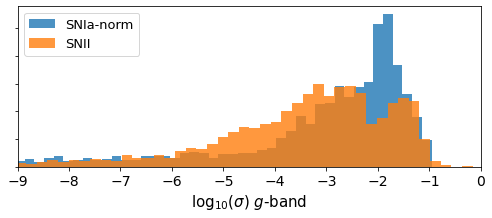

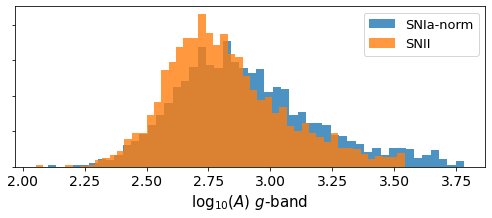

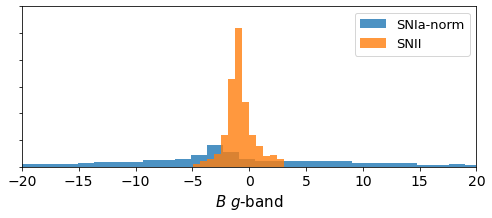

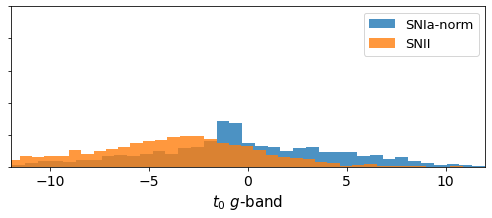

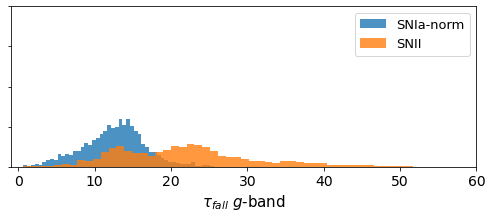

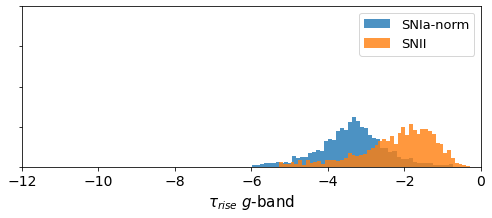

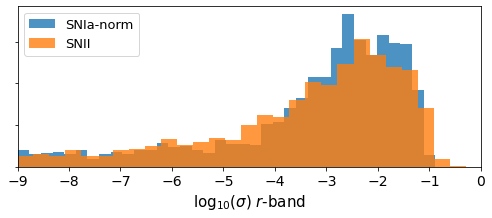

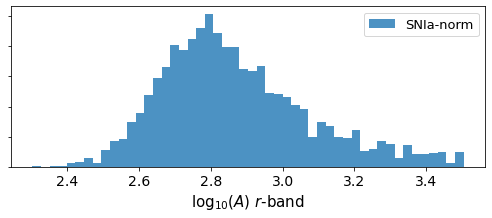

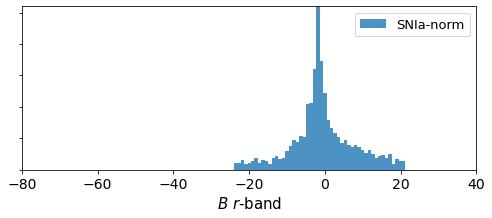

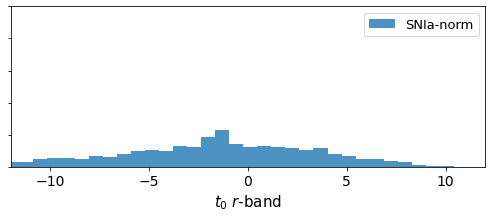

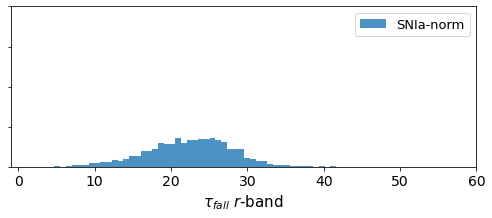

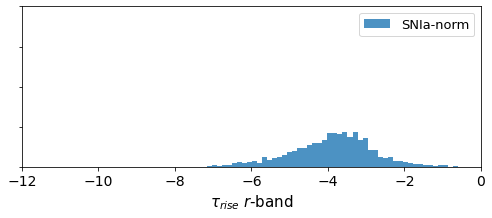

In [9]:
# Compare different classes bazin paramters as histograms
ndim = 6
passbands = ('g', 'r')

for class_num in [1, 2, 3, 51, 60, 64]:
    with open(f'save_bazin_params_class_multipb_{class_num}_041020_nopriors_resetx0_allobjects_usingonlygoodobjects.pickle', 'rb') as f:
        load_bazin_params = pickle.load(f)
    for pb in passbands:
        params_array = np.array(list(load_bazin_params[pb].values()))

        # Using logA and logsigma
        labels = [r"$\log_{10}(\sigma)$", r"$\log_{10}(A)$", r"$B$", r"$t_0$", r"$\tau_{fall}$", r"$\tau_{rise}$"]
        # params_array[:,0] = np.log10(np.exp(params_array[:,0]))  # params_array[:,0] = np.log10(np.sqrt(params_array[:,0]**2))
        # params_array[:,1] = np.log10(np.exp(params_array[:,1]))
        # labels = [r"$\sigma$", r"$A$", r"$B$", "$t_0$", r"$\tau_{fall}$", r"$\tau_{rise}$"]


        # Compute mean and covariance
        params_array_means = np.mean(params_array, axis=0)
        params_array_sigmas = np.std(params_array, axis=0)
        params_covariance = np.cov(params_array.T)
        print(f"if class_num == {repr(class_num)}:")
        print(f"    if passband == {repr(pb)}:")
        print(f"        means = np.{repr(params_array_means)}")
        print(f"        covariance = np.{repr(params_covariance)}")
        print(f"        inverse_covariance = np.{repr(lin.inv(params_covariance))}")
        # print(f"x0[{repr(class_num)}][{repr(pb)}] = np.{repr(np.median(params_array, axis=0))}")

        # Plot histograms and remove 3 median absolute deviation outliers for plotting
        params_removed_outliers = []
        for i in range(ndim):
            d = abs(params_array[:,i] - np.median(params_array[:,i]))
            mad = np.median(d)
            params_removed_outliers.append(params_array[:,i][d < 5*mad])
        # print(params_array_means, params_array_sigmas)
        for i in range(ndim):
            fig = plt.figure(f"{i}_{pb}", figsize=(7,3.2))
            ax1 = plt.gca()
            nbins = 50
            if labels[i] == r"$B$" and pb == 'g' and class_num in [2,51]:
                nbins = 13
            elif labels[i] == r"$t_0$" and pb == 'g' and class_num in [51,]:
                nbins = 20
            elif labels[i] in [r"$\tau_{fall}$", r"$\tau_{rise}$"] and class_num in [51,]:
                nbins = 20
            ax1.hist(params_removed_outliers[i], bins=nbins, density=True, label=f"{helpers.get_sntypes()[class_num]}", alpha=0.8)
            ax1.set_xlabel(fr"{labels[i]} ${pb}$-band", fontsize=15)
            ax1.legend(fontsize=13)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            ax1.axes.yaxis.set_ticklabels([])
            if labels[i] == r"$\log_{10}(\sigma)$":
                plt.xlim(-9, 0)
            elif labels[i] == r"$B$" and pb == 'g':
                plt.xlim(-20, 20)    
                plt.ylim(0,0.6)    
            if labels[i] == r"$B$" and pb == 'r':
                plt.xlim(-80, 40)  
                plt.ylim(0,0.13)    
            elif labels[i] == r"$t_0$":
                plt.xlim(-12, 12)
                plt.ylim(0,0.5)
            elif labels[i] == r"$\tau_{fall}$":
                plt.xlim(-1, 60)
                plt.ylim(0, 0.4)
            #     ax1.legend(fontsize=13, loc='upper right')
            elif labels[i] == r"$\tau_{rise}$":
                plt.xlim(-12,0)
                plt.ylim(0,2)
            plt.tight_layout()
            plt.savefig(f"{i}_{pb}.png")

In [ ]:
#@title MCMC bazin fit to plasticc data
# ! pip install emcee
# ! pip install corner

import emcee
import corner

labels = ["sigma", "A", "B", "t0", "taufall", "taurise"]
pb = 'g'

save_bazin_params = {}
for objidx, (objid, lc) in enumerate(light_curves.items()):
    if objidx>3: break
    print(objidx, objid)
    try:
        pbmask = lc['passband'] == pb
        time = lc[pbmask]['time'].data
        flux = lc[pmask]['flux'].data
        fluxerr = lc[pbmask]['fluxErr'].data
        photflag = lc[pbmask]['photflag'].data

        # Mask out times outside of mintime and maxtime
        timemask = (time > -70) & (time < 80)
        time = time[timemask]
        flux = flux[timemask]
        fluxerr = fluxerr[timemask]
        photflag = photflag[timemask]

        def objective_func(theta):
            sigma_intrinsic = theta[0]
            if sigma_intrinsic < 0:
                return -np.inf
            return log_posterior(time, flux, fluxerr, fit_until, sigma_intrinsic=theta[0], A=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np)


        pos = res.x + 1e-4 * np.random.randn(100, len(res.x))
        nwalkers, ndim = pos.shape
        print(nwalkers, ndim)

        sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_func)
        sampler.run_mcmc(pos, 2000, progress=True);
        samples = sampler.get_chain(discard=200, flat=True)

        # fig = corner.corner(samples, labels=labels, truths=res.x);

        # print mcmc 16th, 50th and 84th percentiles
        print("\nMCMC 16th, 50th, and 84th percentiles")
        badfit = False
        param_vals = []
        for i in range(ndim):
            mcmc = np.percentile(samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = f"{labels[i]} = {mcmc[1]:.2f} (+{q[0]:.2f}) (-{q[1]:.2f})"
            print(txt)
            param_vals.append(mcmc[1])
            if q[0] > 1e5 or q[1] > 1e5:
                print("Bad fit for", objid, i, q[0], q[1])
                badfit = True
                break
        if badfit:
            continue

        # Save best values
        save_bazin_params[objid] = param_vals

        # Plot draws
        plt.figure()
        t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
        # plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
        plt.errorbar(time, flux, yerr=fluxerr, label='true - used for fitting', fmt='.')
        plt.plot(t_plot, y_pred_plot, label='pred')
        plt.axvspan(t_all[np.argmax(t_data)+1], max(t_all), alpha=0.2, color='grey')
        save_y_pred_draws = []
        for i in range(100):
            sample_idx = np.random.randint(low=0, high=samples.shape[0])
            t_draw, y_pred_draw = get_y_pred(80, *samples[sample_idx][1:])
            plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
            save_y_pred_draws.append(y_pred_draw)
        plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
        plt.legend()
        plt.xlabel('Time in days')
        plt.ylabel('Flux')
        plt.title(f"{objidx}  {objid}")
        plt.show()
        # plt.ylim(bottom=-10, top=70)

    except Exception as e:
        print(i, objid, e)
        continue

# import pickle
# with open('save_bazin_params.pickle', 'wb') as f:
#     pickle.dump(save_bazin_params, f)





In [ ]:
# Compare real data to simulated data for SNIa

ndim = 6

with open('save_bazin_params.pickle', 'rb') as f:
    load_bazin_params = pickle.load(f)
params_array = np.array(list(load_bazin_params.values()))
#
with open('save_real_data_from_osc_bazin_params.pickle', 'rb') as f:
    load_bazin_params2 = pickle.load(f)
params_array2 = np.array(list(load_bazin_params2.values()))

# Change to logA and logsigma
labels = ["log(sigma)", "log(A)", "B", "t0", "taufall", "taurise"]
params_array[:,0] = np.log(params_array[:,0])
params_array[:,1] = np.log(params_array[:,1])
#
params_array2[:,0] = np.log(params_array2[:,0])
params_array2[:,1] = np.log(params_array2[:,1])

# Compute mean and covariance
params_array_means = np.mean(params_array, axis=0)
params_array_sigmas = np.std(params_array, axis=0)
params_covariance = np.cov(params_array.T)
print(params_covariance)
#
params_array_means2 = np.mean(params_array2, axis=0)
params_array_sigmas2 = np.std(params_array2, axis=0)
params_covariance2 = np.cov(params_array2.T)
print(params_covariance2)

# Plot histograms and remove 3 sigma outliers for plotting
params_removed_outliers = []
for i in range(ndim):
    params_removed_outliers.append(params_array[:,i][abs(params_array[:,i] - np.median(params_array[:,i])) < 3*np.std(params_array[:,i])])
#
params_removed_outliers2 = []
for i in range(ndim):
    params_removed_outliers2.append(params_array2[:,i][abs(params_array2[:,i] - np.median(params_array2[:,i])) < 3*np.std(params_array2[:,i])])
    
print(params_array_means, params_array_sigmas)
for i in range(ndim):
    plt.figure(figsize=(7,3.2))
    plt.hist(params_removed_outliers[i], bins=50, density=True, label="SNIa ZTF PLAsTiCC sims", alpha=0.5)
    plt.hist(params_removed_outliers2[i], bins=50, density=True, label='SNIa Real data', alpha=0.5)
    plt.xlabel(labels[i])
    ax1 = plt.gca()
    ax1.legend(fontsize=13)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax1.axes.yaxis.set_ticklabels([])
    plt.tight_layout()
    plt.savefig(f"real_vs_sims_{i}_{pb}")

In [ ]:
# # np.where(~np.isfinite(params_array))
# params_covariance
# params_array_means
params_array

In [ ]:
params_covariance
np.linalg.inv(params_covariance)
# params_array_means
# np.median(fluxerr)

In [ ]:
#@title Check univariate vs multivariate gaussian priors

# x = np.array([sigma_intrinsic, A, B, t0, tau_fall, tau_rise])
# means = np.array([24.9723914 , 890.8069568 , -26.34104599,  -3.4609063 ,
#                   16.20697774,  -3.40826335])
# covariance = np.array([[ 1.74474637e+02,  2.18543822e+03, -2.70052169e+02,
#                           7.41085359e+00,  1.41350541e+01, -1.71021825e+00],
#                         [ 2.18543822e+03,  2.88251062e+05, -9.25276312e+04,
#                           6.59647012e+02,  2.79607128e+03, -3.53338108e+02],
#                         [-2.70052169e+02, -9.25276312e+04,  6.81433971e+04,
#                           5.16278048e+02, -2.50140730e+03,  2.49325353e+02],
#                         [ 7.41085359e+00,  6.59647012e+02,  5.16278048e+02,
#                           4.14864470e+01, -3.13248842e+01,  1.02721038e+00],
#                         [ 1.41350541e+01,  2.79607128e+03, -2.50140730e+03,
#                           -3.13248842e+01,  1.17189022e+02, -9.34560249e+00],
#                         [-1.71021825e+00, -3.53338108e+02,  2.49325353e+02,
#                           1.02721038e+00, -9.34560249e+00,  1.72261655e+00]])
# n = len(means)
# inverse_covariance = np.array([[6.78744316e-03, -9.29642223e-05, -2.28506150e-04,
#                                     8.05930286e-04, -2.90254365e-03,  4.51563295e-03],
#                                   [-9.29642223e-05,  1.01991443e-05,  2.03397428e-05,
#                                     -3.17739063e-04,  1.00292910e-04, -2.10594624e-04],
#                                   [-2.28506150e-04,  2.03397428e-05,  1.24103770e-04,
#                                     -4.10170214e-04,  1.73313886e-03, -4.36989143e-03],
#                                   [ 8.05930286e-04, -3.17739063e-04, -4.10170214e-04,
#                                     4.35185650e-02,  1.39113687e-02,  4.45149742e-02],
#                                   [-2.90254365e-03,  1.00292910e-04,  1.73313886e-03,
#                                     1.39113687e-02,  4.92597661e-02,  2.57922494e-02],
#                                   [ 4.51563295e-03, -2.10594624e-04, -4.36989143e-03,
#                                     4.45149742e-02,  2.57922494e-02,  1.28766568e+00]])
# log_prior = -(n/2)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covariance)) - 0.5 * (x-means) @ inverse_covariance @ (x-means)
# print(log_prior)

# sigma_intrinsic, A, B, t0, tau_fall, tau_rise = x
# # sigma_intrinsic prior
# sigma_intrinsic_mean = means[0]
# sigma_intrinsic_sigma = np.sqrt(np.diagonal(covariance)[0])
# sigma_log_prior = -0.5*np.log(2*np.pi*sigma_intrinsic_sigma**2)-0.5*(sigma_intrinsic-sigma_intrinsic_mean)**2/sigma_intrinsic_sigma**2

# # A prior
# A_mean = means[1]
# A_sigma = np.sqrt(np.diagonal(covariance)[1])
# A_log_prior = -0.5*np.log(2*np.pi*A_sigma**2)-0.5*(A-A_mean)**2/A_sigma**2

# # B prior
# B_mean = means[2]
# B_sigma = np.sqrt(np.diagonal(covariance)[2])
# B_log_prior = -0.5*np.log(2*np.pi*B_sigma**2)-0.5*(B-B_mean)**2/B_sigma**2

# # t0 prior
# t0_mean = means[3]
# t0_sigma = np.sqrt(np.diagonal(covariance)[3])
# t0_log_prior = -0.5*np.log(2*np.pi*t0_sigma**2)-0.5*(t0-t0_mean)**2/t0_sigma**2

# # tau_fall prior
# tau_fall_mean = means[4]
# tau_fall_sigma = np.sqrt(np.diagonal(covariance)[4])
# tau_fall_log_prior = -0.5*np.log(2*np.pi*tau_fall_sigma**2)-0.5*(tau_fall-tau_fall_mean)**2/tau_fall_sigma**2

# # tau_rise prior
# tau_rise_mean = means[5]
# tau_rise_sigma = np.sqrt(np.diagonal(covariance)[5])
# tau_rise_log_prior = -0.5*np.log(2*np.pi*tau_rise_sigma**2)-0.5*(tau_rise-tau_rise_mean)**2/tau_rise_sigma**2

# log_prior = np.log(1) + sigma_log_prior + A_log_prior + B_log_prior + tau_fall_log_prior + tau_rise_log_prior
# print(log_prior)



-3.78 3.13 -1.97 1.29 26.11 -3.24
Compute Inverse Hessian using Autograd
[[ 3.00491824e+02  2.36983859e-05 -1.80226340e-02 -1.82243449e-03
   1.76011900e-03  2.40162949e-06]
 [ 2.36983858e-05  1.19713719e-06  4.03999272e-05 -4.66112439e-05
  -1.77861352e-05  1.34680655e-05]
 [-1.80226340e-02  4.03999272e-05  2.35760782e-01  2.97917740e-03
  -2.49423399e-02  3.78424763e-03]
 [-1.82243449e-03 -4.66112439e-05  2.97917740e-03  4.72943897e-03
  -1.14211084e-03 -1.28348173e-03]
 [ 1.76011900e-03 -1.77861352e-05 -2.49423399e-02 -1.14211084e-03
   3.82142336e-03 -1.71394520e-04]
 [ 2.40163001e-06  1.34680655e-05  3.78424763e-03 -1.28348173e-03
  -1.71394520e-04  7.72306052e-04]]
[1.73347000e+01 1.09413764e-03 4.85552038e-01 6.87709166e-02
 6.18176622e-02 2.77903950e-02]


log(sigma)    : true=-3.78,   pred=-12.85 +- 17.33
log(A)        : true=3.13, pred=3.13 +- 0.00
B             : true=-1.97,   pred=-1.98 +- 0.49
t0            : true=1.29,  pred=1.29 +- 0.07
tau_fall      : true=26.11,  pred=

(-36.250206049343475, 907.0888563611853)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


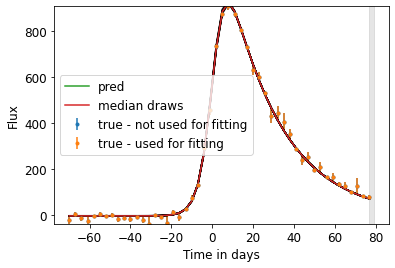

In [10]:
np.random.seed(42)

# Make dataset
t_all = np.arange(-70,80,step=3)
# sigma_intrinsic = np.random.normal(25, 13)  # 5
# A = np.random.normal(891, 536)  # 100
# B = np.random.normal(-26, 260)  # 
# t0 = np.random.normal(-3.5, 6.4)  # 
# tau_fall = np.random.normal(16.2, 10.8)  # 20
# tau_rise = np.random.normal(-3.4, 1.3)  # -6
# print(sigma_intrinsic, A, B, t0, tau_fall, tau_rise)
data_means = np.array([-3.0513051 ,  2.9429629 , -2.3801301 , -0.9164394 , 12.85557161,
       -3.27950949])
data_covariance = np.array([[ 1.06139203e+03,  1.73917773e+00, -8.98891302e+00,
                            2.14136112e+01, -2.71966602e+03,  3.34045506e+01],
                            [ 1.73917773e+00,  6.48383301e-01, -4.65766792e-02,
                            6.16287709e-01,  3.44283686e+00, -6.20808732e-01],
                            [-8.98891302e+00, -4.65766792e-02,  3.27011585e+00,
                            -1.11229264e+00, -9.66900264e+02, -1.71374944e+01],
                            [ 2.14136112e+01,  6.16287709e-01, -1.11229264e+00,
                            9.70713134e+01, -1.96169549e+02,  3.66498426e+01],
                            [-2.71966602e+03,  3.44283686e+00, -9.66900264e+02,
                            -1.96169549e+02,  1.15393739e+07,  9.86934169e+01],
                            [ 3.34045506e+01, -6.20808732e-01, -1.71374944e+01,
                            3.66498426e+01,  9.86934169e+01,  9.24732075e+02]])

log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise = np.array([-3.78, 3.13, -1.97, 1.29, 26.11, -3.24])#np.random.multivariate_normal(data_means, data_covariance)

print(log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise)
fit_until = 79  # 30
t_data, y_data, yerr, t_all, y_data_all, yerr_all = get_y_data(fit_until, 10**log_sigma_intrinsic, 10**logA, B, t0, tau_fall, tau_rise, seed=0, t_all=t_all)
# t_data, y_data, yerr =  time[pb], flux[pb], fluxerr[pb]
class_num = 1
pb = 'g'

# x0 = data_means
autograd_numpy = False

# Optimise
def objective_func(theta):
    if autograd_numpy:
        np1 = autograd.numpy
    else:
        np1 = np

    return -log_posterior(class_num, pb, t_data, y_data, yerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)

res = minimize(objective_func, x0[class_num][pb], method='Nelder-Mead', options={'disp': True})

# # Compute hessian in two ways
# print("Get Inverse Hessian from BFGS optimiser")
# hessian_inv = res.hess_inv
# print(hessian_inv)
print("Compute Inverse Hessian using Autograd")
autograd_numpy = True
hessian_ = autograd.hessian(objective_func)
autograd_hessian_inv = lin.inv(hessian_(res.x))
print(autograd_hessian_inv)

# Get Uncertaintites
cov_matrix = autograd_hessian_inv
sigmas = np.sqrt(np.diagonal(cov_matrix))
print(sigmas)


# Print comparisons
print("\n")
print(f"log(sigma)    : true={log_sigma_intrinsic},   pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
print(f"log(A)        : true={logA}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
print(f"B             : true={B},   pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
print(f"t0            : true={t0},  pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
print(f"tau_fall      : true={tau_fall},  pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
print(f"tau_rise      : true={tau_rise},  pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")


# Plot
t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
plt.errorbar(t_data, y_data, yerr=yerr, label='true - used for fitting', fmt='.')
plt.plot(t_plot, y_pred_plot, label='pred')
plt.axvspan(fit_until, max(t_all), alpha=0.2, color='grey')

# Draw random parameter functions
save_y_pred_draws = []
for i in range(100):
    param_draws = np.random.multivariate_normal(res.x, cov_matrix)
    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
    plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
    save_y_pred_draws.append(y_pred_draw)
plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')

plt.legend()
plt.xlabel('Time in days')
plt.ylabel('Flux')
plt.ylim(bottom=min(y_data_all), top=max(y_data_all))

In [ ]:
# ## MCMC fit
# ! pip install emcee
# ! pip install corner
# ! pip install chainconsumer
import emcee
import corner
labels = ["log(sigma)", "log(A)", "B", "t0", "taufall", "taurise"]

for fit_until in range(-70, 80, 3):
    def objective_func(theta):
        # return log_posterior(class_num, pb, time, flux, fluxerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np)
        return log_posterior(class_num, pb, t_data, y_data, yerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np)


    pos = res.x + 1e-4 * np.random.randn(100, len(res.x))
    nwalkers, ndim = pos.shape
    print(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_func)
    sampler.run_mcmc(pos, 1000, progress=True);
    samples = sampler.get_chain(discard=200, flat=True)

    fig = corner.corner(samples, labels=labels, truths=[log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise]);

    # fig = corner.corner(samples, labels=labels, truths=res.x);

    # print mcmc 16th, 50th and 84th percentiles
    txts = []
    print("\nMCMC 16th, 50th, and 84th percentiles")
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = f"{labels[i]} = {mcmc[1]:.2f} (+{q[0]:.2f}) (-{q[1]:.2f})"
        # print(txt)
        txts.append(f"{mcmc[1]:.2f} (+{q[0]:.2f}) (-{q[1]:.2f})")


    # Plot draws
    plt.figure()
    # t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
    plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
    plt.errorbar(t_data, y_data, yerr=yerr, label='true - used for fitting', fmt='.')
    # plt.errorbar(time, flux, yerr=fluxerr, label='true - used for fitting', fmt='.')
    # plt.plot(t_plot, y_pred_plot, label='pred')
    plt.axvspan(fit_until, max(t_all), alpha=0.2, color='grey')
    save_y_pred_draws = []
    for i in range(100):
        sample_idx = np.random.randint(low=0, high=samples.shape[0])
        t_draw, y_pred_draw = get_y_pred(80, *samples[sample_idx][1:])
        plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
        save_y_pred_draws.append(y_pred_draw)
    plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
    plt.legend()
    plt.xlabel('Time in days')
    plt.ylabel('Flux')
    # plt.ylim(bottom=-10, top=70)

    print("\nMLE with sigmas from inverse Hessian")
    print(f"log(sigma)    : true={log_sigma_intrinsic}, pred=={txts[0]}")#{res.x[0]:.2f} +- {sigmas[0]:.2f}")
    print(f"log(A)        : true={logA}, pred={txts[1]}")#{res.x[0]:.2f} +- {sigmas[0]:.2f}")
    print(f"B             : true={B},   pred={txts[2]}")#{res.x[1]:.2f} +- {sigmas[1]:.2f}")
    print(f"t0            : true={t0},  pred={txts[3]}")#{res.x[2]:.2f} +- {sigmas[2]:.2f}")
    print(f"tau_fall      : true={tau_fall},  pred={txts[4]}")#{res.x[3]:.2f} +- {sigmas[3]:.2f}")
    print(f"tau_rise      : true={tau_rise},  pred={txts[5]}")#{res.x[4]:.2f} +- {sigmas[4]:.2f}")


In [ ]:
#@title Fit Bazin simulations at multiple time steps single passband

for fit_until in range(-70, 80, 3):
    t_data, y_data, yerr, t_all, y_data_all, yerr_all = get_y_data(fit_until, np.exp(log_sigma_intrinsic), np.exp(logA), B, t0, tau_fall, tau_rise, seed=0, t_all=t_all)
    
    def objective_func(theta):
        if autograd_numpy:
            np1 = autograd.numpy
        else:
            np1 = np

        return -log_posterior(t_data, y_data, yerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)

    res = minimize(objective_func, x0, method='BFGS', options={'xatol': 1e-8, 'disp': True})

    # Compute hessian in two ways
    # print("Compute Inverse Hessian using Autograd")
    autograd_numpy = True
    hessian_ = autograd.hessian(objective_func)
    autograd_hessian_inv = lin.inv(hessian_(res.x))
    # print(autograd_hessian_inv)

    # Get Uncertaintites
    cov_matrix = autograd_hessian_inv
    sigmas = np.sqrt(np.diagonal(cov_matrix))
    print(sigmas)
    if np.any(np.isnan(cov_matrix)):
        print("covariance matrix has nans", fit_until, cov_matrix)
        continue

    t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])

    plt.figure()
    plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
    plt.errorbar(t_data, y_data, yerr=yerr, label='true - used for fitting', fmt='.')
    plt.plot(t_plot, y_pred_plot, label='pred')
    plt.axvspan(fit_until, max(t_all), alpha=0.2, color='grey')

    # Draw random parameter functions
    save_y_pred_draws = []
    for i in range(100):
        param_draws = np.random.multivariate_normal(res.x, cov_matrix)
        t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
        plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
        save_y_pred_draws.append(y_pred_draw)
    plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')

    plt.legend()
    plt.xlabel('Time in days')
    plt.ylabel('Flux')
    plt.ylim(bottom=min(y_data_all), top=max(y_data_all))
    plt.show()


    # Print comparisons
    print("\n")
    print(fit_until)
    print(f"log(sigma)    : true={log_sigma_intrinsic},   pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
    print(f"log(A)        : true={logA}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
    print(f"B             : true={B},   pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
    print(f"t0            : true={t0},  pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
    print(f"tau_fall      : true={tau_fall},  pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
    print(f"tau_rise      : true={tau_rise},  pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")



In [ ]:
# Fit actual light curves with Bazin function at different time steps
import warnings
from transomaly import helpers

class_num = 1
passbands = ('g', 'r')
nobjidx = len(light_curves_sims[class_num].items())
save_flux_pred = {}
save_fluxerr_pred = {}
save_flux_interp = {}
save_fluxerr_interp = {}

for objidx, (objid, lc) in enumerate(light_curves_sims[51].items()):
    if objidx != 13:
        continue
    print(f"{objidx} of {nobjidx}", objid)
    save_flux_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
    save_fluxerr_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
    save_flux_interp[objidx] = {pb: np.zeros(50) for pb in passbands}
    save_fluxerr_interp[objidx] = {pb: np.zeros(50) for pb in passbands}

    for f, fit_until in enumerate(range(-70, 80, 3)):
        print(f"objidx: {objidx}, timestep: {f}")
        plt.close()
        try:
            time, flux, fluxerr, photflag = {}, {}, {}, {}
            t_pred1, y_pred1 = {}, {}
            respb = {}
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time[pb] = lc[pbmask]['time'].data
                flux[pb] = lc[pbmask]['flux'].data
                fluxerr[pb] = lc[pbmask]['fluxErr'].data
                photflag[pb] = lc[pbmask]['photflag'].data

                # Mask out times outside of mintime and maxtime
                timemask = (time[pb] > -70) & (time[pb] < 80)
                time[pb] = time[pb][timemask]
                flux[pb] = flux[pb][timemask]
                fluxerr[pb] = fluxerr[pb][timemask]
                photflag[pb] = photflag[pb][timemask]
                if np.max(flux[pb]) < 1e-5:
                    print(objidx, objid, "Low flux due to incorrect zeropoints")
                    continue

                # Only fit up to day `fit_until`
                mask = (time[pb] <= fit_until) & (time[pb] >= -70)
                time[pb] = time[pb][mask]
                flux[pb] = flux[pb][mask]
                fluxerr[pb] = fluxerr[pb][mask]
                photflag[pb] = photflag[pb][mask]

                # Optimise fit
                autograd_numpy = False
                def objective_func(theta):
                    if autograd_numpy:
                        np1 = autograd.numpy
                    else:
                        np1 = np

                    return -log_posterior(class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)
                res = minimize(objective_func, x0[class_num][pb], method='Nelder-Mead', options={'xatol': 1e-12, 'disp': False})
                respb[pb] = res

                # print("Compute Covariance Matrix using Autograd")
                autograd_numpy = True
                hessian_ = autograd.hessian(objective_func)
                autograd_hessian_inv = lin.inv(hessian_(res.x))
                # print(autograd_hessian_inv)
                # Get Uncertaintites
                cov_matrix = autograd_hessian_inv
                sigmas = np.sqrt(np.diagonal(cov_matrix))
                # print(sigmas)

                # Ignore bad fits
                if np.any(np.isnan(cov_matrix)) or np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or res.x[1] <= 0 or np.any(np.isnan(res.x)):
                    print(f"Bad fit for objid {objidx} {objid}. Params: {res.x} sigmas {sigmas}")
                    continue
                

                # Plot draws
                t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
                t_pred1[pb] = t_plot
                y_pred1[pb] = y_pred_plot

                time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
                spl = helpers.ErrorPropagationSpline(time_all, flux_all, fluxerr_all, k=1, N=100, ext='zeros')
                fluxinterp, fluxerrinterp = spl(t_plot)

                if time[pb].size == 0 or fit_until > time_all[-1] or fit_until >= t_plot[-1]:
                    continue
    
                # plt.figure()
                # plt.errorbar(time_all, flux_all, yerr=fluxerr_all, label='true - not used for fitting', fmt='.')
                # plt.errorbar(time[pb], flux[pb], yerr=fluxerr[pb], label='true - used for fitting', fmt='.')
                # plt.plot(t_plot, y_pred_plot, label='pred')
                # # plt.axvspan(time_all[np.argmax(time[pb])+1], max(time_all), alpha=0.2, color='grey')
                # plt.axvspan(fit_until, 80, alpha=0.2, color='grey')
                # save_y_pred_draws = []
                # for i in range(100):
                #     with warnings.catch_warnings():
                #         warnings.simplefilter("ignore")
                #         param_draws = np.random.multivariate_normal(res.x, cov_matrix)
                #     t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                #     save_y_pred_draws.append(y_pred_draw)
                #     # One of these Y-pred_draws has a first prediction of 10**24

                #     plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
                # plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
                # plt.legend()
                # plt.xlabel('Time in days')
                # plt.ylabel(f'Flux {pb} band')
                # plt.title(f"{objidx}  {objid}")
                # plt.ylim(bottom=min(0, min(flux_all), min(y_pred_plot)), top=max(max(flux_all), max(y_pred_plot)))
                # # plt.xlim(left=max(-70, min(time_all)), right = min(80, max(time_all)))
                # plt.xlim(-70, 80)
                # plt.show()

                # # # Print best fit parameters
                # # print("\n")
                # # print(f"log(sigma)    : initial={x0[0]}, pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
                # # print(f"log(A)        : initial={x0[1]}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
                # # print(f"B             : initial={x0[2]}, pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
                # # print(f"t0            : initial={x0[3]}, pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
                # # print(f"tau_fall      : initial={x0[4]}, pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
                # # print(f"tau_rise      : initial={x0[5]}, pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")

                # save_flux_pred[objidx][pb][f+1] = y_pred_plot[f+1]
                # save_fluxerr_pred[objidx][pb][f+1] = np.std(save_y_pred_draws, axis=0)[f+1]
                # save_flux_interp[objidx][pb][f+1] = fluxinterp[f+1]
                # save_fluxerr_interp[objidx][pb][f+1] = fluxerrinterp[f+1]


            # Figures for paper    
            fig, (ax1) = plt.subplots(nrows=1, ncols=1)
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
                ax1.errorbar(time_all, flux_all, yerr=fluxerr_all, label=f'${pb}$ band obs', fmt='.', color=COLPB[pb])
                # ax1.axvspan(fit_until, 80, alpha=0.2, color='grey')
                ax1.axvspan(-67, fit_until, alpha=0.2, color='grey')
                save_y_pred_draws = []
                for i in range(100):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
                    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                    save_y_pred_draws.append(y_pred_draw)
                    ax1.plot(t_draw, y_pred_draw, color=COLPB[pb], alpha=0.05)
                ax1.plot(t_draw, np.median(save_y_pred_draws, axis=0), label=f'${pb}$ band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median
                # ax1.plot(t_draw, get_y_pred(80, *respb[pb].x[1:])[1], label=f'${pb}$ optimiser', linestyle='--', color=COLPB[pb])
                # ax1.plot(t_draw, get_y_pred(80, *x0[class_num][pb][1:])[1], label=f'${pb}$ initial fit', linestyle='-.', alpha=0.3)
            ax1.set_ylabel("Relative flux", fontsize=15)
            ax1.set_xlabel("Time since trigger [days]", fontsize=15)
            ax1.legend(fontsize=13.5)#, bbox_to_anchor=(1.6, 1), loc='upper left')
            # plt.ylim(bottom=min(0, min(flux_all), min(y_pred_plot)), top=max(max(flux_all), max(y_pred_plot)))
            text = f"$\log{{\sigma}} = {round(res.x[0],2)}, \log{{A}} = {round(res.x[1],2)}, B = {round(res.x[2],2)}, t_0 = {round(res.x[3],2)}, t_{{fall}} = {round(res.x[4],2)}, t_{{rise}} = {round(res.x[5],2)}$"
            print(text)
            # plt.text(0.1, 0.9, text, transform=fig.transFigure)
            plt.ylim(-200, 1200)  #
            plt.ylim()
            plt.xlim(-67, 77)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.tight_layout()
            plt.savefig(f"bazin_fit_example_timestep_{f}.pdf")
            plt.show()


        except Exception as e:
            print(objidx, objid, e)
            continue

    # #Compute likelihood and mask out where there is no data
    # for pb in passbands:
    #     mask = (save_fluxerr_pred[objidx][pb] != 0)
    #     yt = save_flux_interp[objidx][pb][mask]
    #     yterr = save_fluxerr_interp[objidx][pb][mask]
    #     yp = save_flux_pred[objidx][pb][mask]
    #     yperr = save_fluxerr_pred[objidx][pb][mask]

    #     negloglike = -0.5 * (yt - yp)**2 / (yterr*2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi)
    #     print(negloglike)
    #     fig = plt.figure()
    #     plt.errorbar(t_plot, save_flux_pred[objidx][pb], yerr=save_fluxerr_pred[objidx][pb], label='pred', fmt='.', linestyle='-')   
    #     plt.errorbar(t_plot, save_flux_interp[objidx][pb], yerr=save_fluxerr_interp[objidx][pb], label='interp data', fmt='.', linestyle='-')
    #     # plt.errorbar(time_all[time_all>=-70], flux_all[time_all>=-70], yerr=fluxerr_all[time_all>=-70], label='data', fmt='.', linestyle='-')
    #     plt.legend()
    #     plt.xlabel('Time in days')
    #     plt.ylabel(f'Flux {pb} band')
    #     plt.title(f"3 day predictions plotted plot {objidx}  {objid}")
    #     plt.ylim(bottom=min(0, min(save_flux_pred[objidx][pb]), min(save_flux_interp[objidx][pb])), top=max(max(save_flux_pred[objidx][pb]), max(save_flux_interp[objidx][pb])))
    #     # plt.xlim(left=max(-70, min(time_all)), right = min(80, max(time_all)))
    #     plt.xlim(-70, 80)
    #     plt.text(0.6, 0.7, f"$negloglike = {round(np.sum(negloglike, axis=0)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
    #     plt.show()

    # # with open('save_real_data_from_osc_bazin_params.pickle', 'wb') as f:
    # # with open(f'save_bazin_params_class_multipb_{class_num}.pickle', 'wb') as f:
    # #     pickle.dump(save_bazin_params, f)


In [12]:
# title Similarity matrix function definitions
import json
import random
import pandas as pd
import matplotlib .pyplot as plt
import matplotlib
font = {'family': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

sntypes_map = helpers.get_sntypes()

def get_similarity_matrix(model_class_nums, test_class_nums):

    similarity_matrix = {}
    similarity_matrix_chi2 = {}
    anomaly_scoreslist_chi2_dict = {}
    for class_num in model_class_nums:
        class_name = sntypes_map[class_num]
        print(class_name)
        saved_scores_fp = f'bazin_similarity_scores_{class_num}_-20to55_4000objects_cumsum-newbetterpriors_moretestclasses.json'
  
        if os.path.exists(saved_scores_fp):
            print("Using saved similarity scores")
            with open(saved_scores_fp, 'r') as fp:
                similarity_score = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'similarity_scores_chi2_'), 'r') as fp:
                similarity_score_chi2 = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scoreslist_chi2'), 'r') as fp:
                anomaly_scoreslist_chi2 = json.load(fp)
        else:
            print("Saving similarity scores...")
            similarity_score, similarity_score_chi2, anomaly_scoreslist_chi2 = similarity_metric(class_num, class_nums_to_test_against=test_class_nums)
            with open(saved_scores_fp, 'w') as fp:
                json.dump(similarity_score, fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'similarity_scores_chi2_'), 'w') as fp:
                json.dump(similarity_score_chi2, fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scoreslist_chi2'), 'w') as fp:
                json.dump(anomaly_scoreslist_chi2, fp)
        similarity_matrix[class_name] = similarity_score
        similarity_matrix_chi2[class_name] = similarity_score_chi2
        anomaly_scoreslist_chi2_dict[class_name] = anomaly_scoreslist_chi2

    similarity_matrix = pd.DataFrame(similarity_matrix)
    similarity_matrix_chi2 = pd.DataFrame(similarity_matrix_chi2)

    similarity_matrix.to_csv('bazin_similarity_matrix.csv')
    similarity_matrix_chi2.to_csv('similarity_matrix_chi2.csv')

    print(similarity_matrix)

    return similarity_matrix, similarity_matrix_chi2, anomaly_scoreslist_chi2_dict


def similarity_metric(class_num, class_nums_to_test_against):
    model_class_num = class_num
    model_class_name = sntypes_map[model_class_num]

    nobjidx = len(light_curves_sims[class_num].items())
    save_flux_pred = {}
    save_fluxerr_pred = {}
    save_flux_interp = {}
    save_fluxerr_interp = {}
    save_flux_pred_draws = {}

    class_names = [sntypes_map[class_num] for class_num in class_nums_to_test_against]
    anomaly_scores = {key: [] for key in class_names}
    anomaly_scores_chi2 = {key: [] for key in class_names}

    # all_lcs_dict = {**light_curves_sims[1], **light_curves_sims[2], **light_curves_sims[3], **light_curves_sims[51], **light_curves_sims[60], **light_curves_sims[64], **light_curves_sims[61], **light_curves_sims[62], **light_curves_sims[63], **light_curves_sims[90], **light_curves_sims[92]}
    all_lcs_dict = {}
    for c in test_class_nums:
        all_lcs_dict.update(light_curves_sims[c])
    
    objids = list(all_lcs_dict.keys())
    random.shuffle(objids)

    ndraws = 100

    for objidx, objid in enumerate(objids):
        ylims_paper_objids = {'1_132490785': (-300, 2400), '2_113673268': (-350, 1100), '3_125078236': (-600, 1700), '51_107222452': (-350, 600), '60_39476620': (-400, 2400), '64_31366754': (-150, 800)}  # '51_107222452': (-3, 1200)
        # if objid not in ['1_132490785', '2_113673268', '3_125078236', '51_107222452', '60_39476620', '64_31366754']:
        #     continue
        # if class_num != int(objid.split('_')[0]) or (class_num == 1 and objid[:2] == '51'): #1
        #     continue
        if objidx > 4000:
            break
        lc = all_lcs_dict[objid]
        obj_class_num = int(objid.split('_')[0])
        obj_class_name = sntypes_map[obj_class_num]

        save_flux_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
        save_fluxerr_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
        save_flux_pred_draws[objidx] = {pb: np.zeros((50, ndraws)) for pb in passbands}
        save_flux_interp[objidx] = {pb: np.zeros(50) for pb in passbands}
        save_fluxerr_interp[objidx] = {pb: np.zeros(50) for pb in passbands}

        for f, fit_until in enumerate(range(-70, 80, 3)):
            # if fit_until < -20 or fit_until > 55:   # Only for similarity matrix not for paper plots
            #     continue
            if f % 10 == 0: print(f"model_class_num: {class_num}, objidx: {objidx} of {len(objids)}, {objid} timestep: {f}")
            plt.close()
            time, flux, fluxerr, photflag = {}, {}, {}, {}
            t_pred1, y_pred1 = {}, {}
            respb = {}
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time[pb] = lc[pbmask]['time'].data
                flux[pb] = lc[pbmask]['flux'].data
                fluxerr[pb] = lc[pbmask]['fluxErr'].data
                photflag[pb] = lc[pbmask]['photflag'].data

                # Mask out times outside of mintime and maxtime
                timemask = (time[pb] > -70) & (time[pb] < 80)
                time[pb] = time[pb][timemask]
                flux[pb] = flux[pb][timemask]
                fluxerr[pb] = fluxerr[pb][timemask]
                photflag[pb] = photflag[pb][timemask]
                # if len(flux[pb]) < 0:
                #     print(objidx, objid, "Not enough flux points")
                #     continue

                # Only fit up to day `fit_until`
                mask = (time[pb] <= fit_until) & (time[pb] >= -70)
                time[pb] = time[pb][mask]
                flux[pb] = flux[pb][mask]
                fluxerr[pb] = fluxerr[pb][mask]
                photflag[pb] = photflag[pb][mask]

                # Optimise fit
                autograd_numpy = False
                def objective_func(theta):
                    if autograd_numpy:
                        np1 = autograd.numpy
                    else:
                        np1 = np

                    return -log_posterior(model_class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)
                res = minimize(objective_func, x0[model_class_num][pb], method='Nelder-Mead', options={'xatol': 1e-12, 'disp': False})
                respb[pb] = res

                # print("Compute Covariance Matrix using Autograd")
                autograd_numpy = True
                hessian_ = autograd.hessian(objective_func)
                autograd_hessian_inv = lin.inv(hessian_(res.x))
                # print(autograd_hessian_inv)
                # Get Uncertaintites
                cov_matrix = autograd_hessian_inv
                sigmas = np.sqrt(np.diagonal(cov_matrix))
                # print(sigmas)

                bad_covariance = False
                # Ignore bad fits
                if np.any(np.isnan(cov_matrix)) or np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or np.any(np.isnan(res.x)):
                    # print(f"Bad fit for objid {objidx} {objid} {pb}. Params: {res.x} sigmas {sigmas}")
                    bad_covariance = True
                    # continue

                # Get draws
                t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
                t_pred1[pb] = t_plot
                y_pred1[pb] = y_pred_plot
                save_y_pred_draws = []
                for i in range(ndraws):
                    if bad_covariance:
                        t_draw, y_pred_draw = get_y_pred(80, *respb[pb].x[1:])
                    else:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
                        t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                    save_y_pred_draws.append(y_pred_draw)

                try:
                    time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
                    spl = helpers.ErrorPropagationSpline(time_all, flux_all, fluxerr_all, k=1, N=100, ext='zeros')
                    fluxinterp, fluxerrinterp = spl(t_plot)
                except Exception as e:
                    print("Error in spline", e)
                    continue

                if time[pb].size == 0 or fit_until > time_all[-1] or fit_until >= t_plot[-1]:
                    continue

                save_flux_pred[objidx][pb][f+1] = y_pred_plot[f+1]
                save_fluxerr_pred[objidx][pb][f+1] = np.std(save_y_pred_draws, axis=0)[f+1]
                save_flux_pred_draws[objidx][pb][f+1] = np.array(save_y_pred_draws)[:,f+1]
                save_flux_interp[objidx][pb][f+1] = fluxinterp[f+1]
                save_fluxerr_interp[objidx][pb][f+1] = fluxerrinterp[f+1]

            # # Plot fits at different time steps
            # try:
            #     fig, (ax1) = plt.subplots(nrows=1, ncols=1)
            #     for pb in passbands:
            #         pbmask = lc['passband'] == pb
            #         time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
            #         ax1.errorbar(time_all, flux_all, yerr=fluxerr_all, label=f'${pb}$ band obs', fmt='.', color=COLPB[pb])
            #         # ax1.axvspan(fit_until, 80, alpha=0.2, color='grey')
            #         ax1.axvspan(-67, fit_until, alpha=0.2, color='grey')
            #         save_y_pred_draws = []
            #         for i in range(100):
            #             with warnings.catch_warnings():
            #                 warnings.simplefilter("ignore")
            #                 param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
            #             t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
            #             save_y_pred_draws.append(y_pred_draw)
            #             ax1.plot(t_draw, y_pred_draw, color=COLPB[pb], alpha=0.05)
            #         ax1.plot(t_draw, np.median(save_y_pred_draws, axis=0), label=f'${pb}$ band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median
            #         ax1.plot(t_draw, get_y_pred(80, *respb[pb].x[1:])[1], label=f'${pb}$ band optimiser', color=COLPB[pb], linewidth=2, linestyle='--')  # median
            #     ax1.set_ylabel("Relative flux", fontsize=15)
            #     ax1.set_xlabel("Time since trigger [days]", fontsize=15)
            #     ax1.legend(fontsize=13.5)
            #     plt.ylim(bottom=min(0, min(flux_all), min(y_pred_plot)), top=max(max(flux_all), max(y_pred_plot)))
            #     plt.xlim(-67, 77)
            #     plt.xticks(fontsize=15)
            #     plt.yticks(fontsize=15)
            #     plt.tight_layout()
            #     plt.show()
            #     plt.close()
            # except Exception as e:
            #     print(e)

        # Get anomaly scores
        npb = 0
        chi2 = 0
        negloglike = 0
        maskzeros = True
        maskzeros_pb = {}
        mask_npb = 0
        for pb in passbands:
            yt = save_flux_interp[objidx][pb]
            yterr = save_fluxerr_interp[objidx][pb]
            yp = save_flux_pred[objidx][pb]
            yperr = save_fluxerr_pred[objidx][pb]
            maskzeros_pb[pb] = ((yterr != 0) * (np.isfinite(yterr)))
            mask_npb = maskzeros_pb[pb] + mask_npb
            maskzeros = maskzeros_pb[pb] & maskzeros
            try:
                chi2_pb = ((yp - yt)/yterr)**2
                chi2_pb[~np.isfinite(chi2_pb)] = 0
                chi2 += chi2_pb
                negloglike_pb = 0.5 * (yp - yt)**2 / (yterr*2 + yperr**2) + 0.5 *np.log(yterr**2 + yperr**2) + 0.5*np.log(2*np.pi)
                negloglike_pb[~np.isfinite(negloglike_pb)] = 0
                negloglike += negloglike_pb
                npb += 1
            except ValueError as e:
                print(f"Failed chi2 object {objids_test[sidx + s]}", e)
            
        if not np.any(maskzeros):
            print("here not any maskzeros")
            continue

        chi2 = chi2 / mask_npb
        chi2cumsum = np.nancumsum(chi2)/np.arange(1, len(chi2)+1)
        negloglike = negloglike / mask_npb
        negloglikecumsum = np.nancumsum(negloglike)/np.arange(1, len(negloglike)+1)
        
        anomaly_scores_lc = np.array(negloglike)
        anomaly_score_max = np.nanmean(anomaly_scores_lc)  # np.nanmax(anomaly_scores_lc)
        anomaly_scores[obj_class_name].append(anomaly_score_max)

        anomaly_scores_lc_chi2 = np.array(chi2)
        anomaly_score_chi2_max = np.nanmean(anomaly_scores_lc_chi2)  # np.nanmax(anomaly_scores_lc_chi2)
        anomaly_scores_chi2[obj_class_name].append(anomaly_score_chi2_max)
        print(f"Anomaly score is {anomaly_score_chi2_max}")

        # # Example transients for paper
        # # fig, (ax1) = plt.subplots(nrows=1, ncols=1) #1
        # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5.2, 6), sharex=True) #2
        # for pb in passbands:
        #     maskbadfits = [maskzeros_pb[pb]]
        #     pbmask = lc['passband'] == pb
        #     time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
        #     # ax1.errorbar(t_plot, save_flux_pred[objidx][pb], yerr=save_fluxerr_pred[objidx][pb], label=f'${pb}$ band pred', fmt='.', linestyle='-', color='pink')   
        #     # ax1.errorbar(t_plot, save_flux_interp[objidx][pb], yerr=save_fluxerr_interp[objidx][pb], label=f'${pb}$ band interp data', fmt='.', linestyle='-', color='cyan')
        #     ax1.errorbar(time_all, flux_all, yerr=fluxerr_all, label=f'${pb}$-band obs', fmt='.', color=COLPB[pb])
        #     # plt.errorbar(time_all[time_all>=-70], flux_all[time_all>=-70], yerr=fluxerr_all[time_all>=-70], label='data', fmt='.', linestyle='-')
        #     for drawidx in range(ndraws):
        #         ax1.plot(t_plot[maskbadfits], save_flux_pred_draws[objidx][pb][:,drawidx][maskbadfits], color=COLPB[pb], alpha=0.05)
        #     # ax1.plot(t_plot[maskbadfits], np.median(save_flux_pred_draws[objidx][pb][maskbadfits], axis=1), label=f'${pb}$-band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median
        #     ax1.plot(t_plot[maskbadfits], save_flux_pred[objidx][pb][maskbadfits], label=f'${pb}$-band pred', color=COLPB[pb], linewidth=2, linestyle='-') # label='optimiser', linestyle='--')
        #     # ax1.plot(t_plot, get_y_pred(80, *x0[class_num][pb][1:])[1], label='initial fit', linestyle='-.')
        # ax1.tick_params(axis='x', labelsize=15)
        # ax1.tick_params(axis='y', labelsize=15)
        # ax2.tick_params(axis='x', labelsize=15) #2
        # ax2.tick_params(axis='y', labelsize=15) #2
        # ax1.set_ylabel("Relative flux", fontsize=15)
        # # ax1.set_xlabel("Time since trigger [days]", fontsize=15) #1
        # ax2.set_xlabel("Time since trigger [days]", fontsize=15) #2
        # ax2.set_ylabel("Anomaly score", fontsize=15) #2
        # ax2.plot(t_plot, chi2cumsum, lw=2) #2
        # # ax1.legend(frameon=True, fontsize=13, loc='upper left')
        # if objid in ylims_paper_objids:
        #     ax1.set_ylim(*ylims_paper_objids[objid])
        # else:
        #     ax1.set_ylim(bottom=min(0, min(save_flux_pred[objidx][pb]), min(save_flux_interp[objidx][pb])), top=1.2*max(max(save_flux_pred[objidx][pb]), max(save_flux_interp[objidx][pb])))
        # plt.xlim(-67, 77)
        # plt.xlim(max(-67, min(time_all)), min(77, max(time_all)))
        # # plt.text(0.75, 0.85, f"$\chi^2 = {round(max(chi2), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
        # plt.tight_layout()
        # fig.subplots_adjust(hspace=0) #2
        # # plt.savefig(f"bazin_3-day-predictions_model-{model_class_num}_fitting-{objid}.png") #1
        # plt.savefig(f"bazin_3-day-predictions_model-{model_class_num}_fitting-{objid}_withanomalyscoreplot.pdf") #2
        # plt.show()
        # plt.close()

    similarity_score = {key: [] for key in class_names}
    similarity_score_chi2 = {key: [] for key in class_names}
    for c in class_names:
        similarity_score[c] = np.median(anomaly_scores[c])
        similarity_score_chi2[c] = np.median(anomaly_scores_chi2[c])

    return similarity_score, similarity_score_chi2, anomaly_scores_chi2


def plot_similarity_matrix(similarity_matrix):
    font = {'family': 'normal',
            'size': 36}
    matplotlib.rc('font', **font)

    xrange, yrange = similarity_matrix.shape
    similarity_matrix = similarity_matrix.T
    # similarity_matrix = similarity_matrix[
    #     ['SNIa', 'SNIa-x', 'SNII', 'SNIbc', 'SLSN-I', 'TDE', 'AGN', 'SNIIn', 'Ia-91bg', 'CART', 'TDE', 'PISN',
    #      'Kilonova']]
    xlabels = similarity_matrix.columns.values
    ylabels = similarity_matrix.index.values


    minval = 0
    maxval = min(20, similarity_matrix.values.max())
    plt.figure(figsize=(15,12))
    plt.imshow(similarity_matrix, cmap=plt.cm.viridis, vmin=minval, vmax=maxval)#, norm=colors.LogNorm())

    cb = plt.colorbar()
    # cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=27)
    plt.xticks(np.arange(xrange), xlabels, rotation=90, fontsize=27)
    plt.yticks(np.arange(yrange), ylabels, fontsize=27)

    thresh_q3 = 0.75 * maxval
    thresh_q1 = 0.25 * maxval
    for i in range(xrange):
        for j in range(yrange):
            c = similarity_matrix.iloc[j, i]
            if c > 100:
                cell_text = f"{c:.0f}"
            elif c > 10:
                cell_text = f"{c:.1f}"
            else:
                cell_text = f"{c:.2f}"
            plt.text(i, j, cell_text, va='center', ha='center', fontsize=24, color="white" if c < thresh_q1 or c > thresh_q3 else "black")

    plt.ylabel('Trained on')
    plt.xlabel('Tested on')
    plt.tight_layout()
    print("Saving matrix plot...")
    plt.savefig("bazin_similarity_matrix_yterr_and_yperr_4000objectsperclass_-20to55_cumsum2-newbetterpriors_moretestclasses.pdf")

SNIa-norm
Using saved similarity scores
Kilonova
Using saved similarity scores
TDE
Using saved similarity scores


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


            SNIa-norm     Kilonova          TDE
SNIa-norm   29.364180   199.549157    64.248126
SNII        25.174583   222.805994    72.067409
SNIbc       31.370595   301.816415    51.539191
Kilonova   205.725970    84.005728   238.934983
SLSN-I      41.502999   338.960045    47.796436
TDE         31.295488   223.487683    45.012650
PISN        39.054025   140.288206    37.840947
ILOT        41.527233   166.467059    43.278613
CART        26.341031   184.546823    48.638164
uLens-BSR  533.996556  1578.657472  1161.157759
Saving matrix plot...


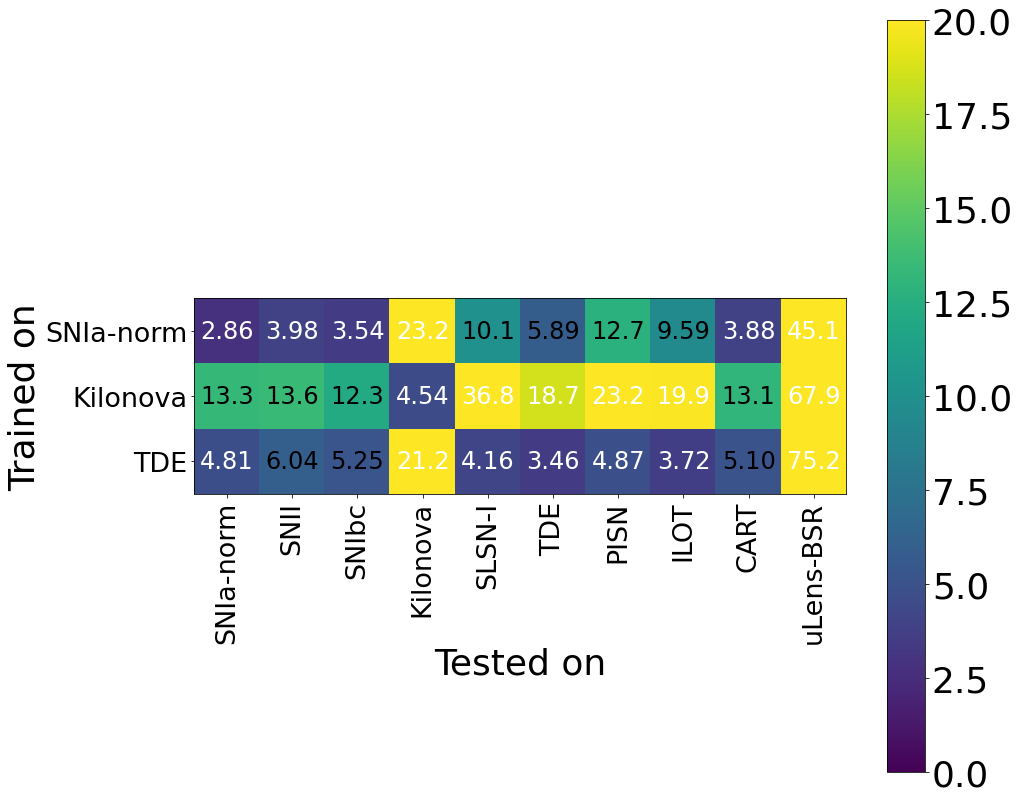

In [13]:
# title # Plot similarity matrix
import warnings
passbands = ('g', 'r')

model_class_nums = [1, 51, 64]#, 3, 51, 60, 64]
test_class_nums = [1, 2, 3, 51, 60, 64, 61, 62, 63, 90]#, 92]

similarity_matrix, similarity_matrix_chi2, anomaly_scoreslist_chi2_dict = get_similarity_matrix(model_class_nums, test_class_nums)
plot_similarity_matrix(similarity_matrix_chi2)

In [ ]:
# list(super_dict.keys())[50000]
anomaly_scoreslist_chi2_dict['SNIa-norm'].keys()

In [ ]:
from transomaly import helpers
sntypes_map = helpers.get_sntypes()
from scipy import stats


font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)

for modelnum in anomaly_scoreslist_chi2_dict.keys():
    print("Using model", modelnum)
    plt.figure(f"Model {modelnum}", figsize=(8,4))
    for cname in ['SNIa-norm', 'SNII', 'SNIbc','CART', 'Kilonova', 'SLSN-I', 'TDE', 'PISN', 'ILOT', 'uLens-BSR']: #anomaly_scoreslist_chi2_dict[modelnum].keys():
        # Remove outliers
        ascores = np.array(anomaly_scoreslist_chi2_dict[modelnum][cname])

        d = abs(ascores - np.median(ascores))
        mad = np.median(d)
        ascores_removed_outliers = ascores[d < 5*mad]
        print(modelnum, len(ascores), len(ascores_removed_outliers))
        nbins = int((ascores_removed_outliers.max() - ascores_removed_outliers.min())*2)
        # plt.hist(ascores_removed_outliers, bins=nbins, label=cname, alpha=0.4)#, range=(0,5))
        kde = stats.gaussian_kde(ascores_removed_outliers)
        x = np.linspace(0, 20, 1000)
        plt.fill_between(x, kde(x), alpha=0.4, label=cname)
    plt.yticks([])
    plt.legend(ncol=2)
    plt.xlabel("Anomaly score")
    plt.xlim(0,20)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig(f"Anomaly_scores_distribution_bazin_{modelnum}_4000objects.pdf")
    plt.show()


In [ ]:
# Make ROC curves
anomaly_scoreslist_chi2_dict
model_classes = ['SNIa-norm', 'Kilonova', 'TDE']

test_classes = ['SNIa-norm', 'SNII', 'SNIbc', 'Kilonova', 'SLSN-I', 'TDE', 'CART', 'PISN', 'ILOT', 'uLens-BSR']

model_transient = 'SNIa-norm'
test_classes.remove(model_transient)
anomalous_transients = ['Kilonova', 'PISN', 'ILOT', 'uLens-BSR'] # test_classes

for model_transient in model_classes:
    tprs = []
    fprs = []
    thresholds = []
    for threshold in np.arange(0, 1000, 1):
        tp = sum(anomaly_scoreslist_chi2_dict[model_transient][model_transient] < threshold)
        fn = sum(anomaly_scoreslist_chi2_dict[model_transient][model_transient] > threshold)
        fp = sum([sum(anomaly_scoreslist_chi2_dict[model_transient][anomaly] < threshold) for anomaly in anomalous_transients])
        tn = sum([sum(anomaly_scoreslist_chi2_dict[model_transient][anomaly] > threshold) for anomaly in anomalous_transients])
        tpr = tp / (tp+fn)  # sensitivity
        fpr = fp / (fp+tn)  # 1 - specificity
    #     print(tp, fn, fp, tn, tpr, fpr)
        tprs.append(tpr)
        fprs.append(fpr)
        thresholds.append(threshold)

    auc = round(np.trapz(tprs, fprs), 3)
    plt.plot(fprs, tprs, label=f"{model_transient} ({auc})")

    for i, threshold in enumerate(thresholds):
        if threshold in [1,2,3,4,5,6,7,8,9,10]:
            plt.annotate(int(thresholds[i]), # this is the text
                        (fprs[i],tprs[i]), # this is the point to label
                        textcoords="offset points", # how to position the text
                        xytext=(0,10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("Bazin_ROC_curve_chi2_with.pdf")
plt.show()

In [ ]:
# Paper plot
npassbands = len(passbands)
ndraws = 100

save_flux_pred = {pb: np.zeros(50) for pb in passbands}
save_fluxerr_pred = {pb: np.zeros(50) for pb in passbands}
save_flux_pred_draws = {pb: np.zeros((50, ndraws)) for pb in passbands}
save_flux_interp = {pb: np.zeros(50) for pb in passbands}
save_fluxerr_interp = {pb: np.zeros(50) for pb in passbands}

paper_objid = "1_18581367"#"1_124486590"  # '1_132490785'
lc_classnum = int(paper_objid.split('_')[0])
lc = light_curves_sims[lc_classnum][paper_objid]
sntypes_map = helpers.get_sntypes()

fig = plt.figure(figsize=(10.4, 6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(223, sharex=ax1)
ax3 = plt.subplot(122)

ascores = []
ascores_nll = []
model_classnums = (1,2,3,51,60,64)
model_classnames = [sntypes_map[c] for c in model_classnums]
for model_classnum in model_classnums:
    for f, fit_until in enumerate(range(-70, 80, 3)):
        time, flux, fluxerr, photflag = {}, {}, {}, {}
        t_pred1, y_pred1 = {}, {}
        respb = {}
        for pbidx, pb in enumerate(passbands):
            pbmask = lc['passband'] == pb
            time[pb] = lc[pbmask]['time'].data
            flux[pb] = lc[pbmask]['flux'].data
            fluxerr[pb] = lc[pbmask]['fluxErr'].data
            photflag[pb] = lc[pbmask]['photflag'].data

            # Mask out times outside of mintime and maxtime
            timemask = (time[pb] > -70) & (time[pb] < 80)
            time[pb] = time[pb][timemask]
            flux[pb] = flux[pb][timemask]
            fluxerr[pb] = fluxerr[pb][timemask]
            photflag[pb] = photflag[pb][timemask]

            # Only fit up to day `fit_until`
            mask = (time[pb] <= fit_until) & (time[pb] >= -70)
            time[pb] = time[pb][mask]
            flux[pb] = flux[pb][mask]
            fluxerr[pb] = fluxerr[pb][mask]
            photflag[pb] = photflag[pb][mask]

            # Optimise fit
            autograd_numpy = False
            def objective_func(theta):
                if autograd_numpy:
                    np1 = autograd.numpy
                else:
                    np1 = np

                return -log_posterior(model_classnum, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)
            res = minimize(objective_func, x0[model_classnum][pb], method='Nelder-Mead', options={'xatol': 1e-12, 'disp': False})
            respb[pb] = res

            # print("Compute Covariance Matrix using Autograd")
            autograd_numpy = True
            hessian_ = autograd.hessian(objective_func)
            autograd_hessian_inv = lin.inv(hessian_(res.x))
            cov_matrix = autograd_hessian_inv
            sigmas = np.sqrt(np.diagonal(cov_matrix))

            bad_covariance = False
            # Ignore bad fits
            if np.any(np.isnan(cov_matrix)) or np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or np.any(np.isnan(res.x)):
                # print(f"Bad fit for objid {objidx} {objid} {pb}. Params: {res.x} sigmas {sigmas}")
                bad_covariance = True
                # continue

            # Get draws
            t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
            t_pred1[pb] = t_plot
            y_pred1[pb] = y_pred_plot
            save_y_pred_draws = []
            for i in range(ndraws):
                if bad_covariance:
                    t_draw, y_pred_draw = get_y_pred(80, *respb[pb].x[1:])
                else:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
                    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                save_y_pred_draws.append(y_pred_draw)

            
            time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
            spl = helpers.ErrorPropagationSpline(time_all, flux_all, fluxerr_all, k=1, N=100, ext='zeros')
            fluxinterp, fluxerrinterp = spl(t_plot)

            if time[pb].size == 0 or fit_until > time_all[-1] or fit_until >= t_plot[-1]:
                continue

            save_flux_pred[pb][f+1] = y_pred_plot[f+1]
            save_fluxerr_pred[pb][f+1] = np.std(save_y_pred_draws, axis=0)[f+1]
            save_flux_pred_draws[pb][f+1] = np.array(save_y_pred_draws)[:,f+1]
            save_flux_interp[pb][f+1] = fluxinterp[f+1]
            save_fluxerr_interp[pb][f+1] = fluxerrinterp[f+1]

            ax1.errorbar(time[pb], flux[pb], yerr=fluxerr[pb], fmt='.', color=COLPB[pb], label=f'${pb}$-band obs')


    print(f"Getting predictions for model {model_classnum}")
    npb = 0
    chi2 = 0
    negloglike = 0
    maskzeros = True
    maskzeros_pb = {}
    mask_npb = 0
    for pbidx, pb in enumerate(passbands):
        pbmask = lc['passband'] == pb
        yt = save_flux_interp[pb]
        yterr = save_fluxerr_interp[pb]
        yp = save_flux_pred[pb]
        yperr = save_fluxerr_pred[pb]
        maskzeros_pb[pb] = ((yterr != 0) * (np.isfinite(yterr)))
        mask_npb = maskzeros_pb[pb] + mask_npb
        maskzeros = maskzeros_pb[pb] & maskzeros
 
        chi2_pb = ((yp - yt)/yterr)**2
        chi2_pb[~np.isfinite(chi2_pb)] = 0
        chi2 += chi2_pb
        negloglike_pb = 0.5 * (yp - yt)**2 / (yterr*2 + yperr**2) + 0.5 *np.log(yterr**2 + yperr**2) + 0.5*np.log(2*np.pi)
        negloglike_pb[~np.isfinite(negloglike_pb)] = 0
        negloglike += negloglike_pb
        npb += 1

    chi2 = chi2 / mask_npb
    chi2cumsum = np.nancumsum(chi2)/np.arange(1, len(chi2)+1)
    negloglike = negloglike / mask_npb
    negloglikecumsum = np.nancumsum(negloglike)/np.arange(1, len(negloglike)+1)
    
    ascores.append(np.nanmean(chi2))
    ascores_nll.append(np.nanmean(negloglike))
    ax2.plot(t_plot, chi2cumsum, lw=2, label=sntypes_map[model_classnum]) #2
    # ax2.text(0.05, 0.95, f"$\chi^2 = {round(np.sum(chi2)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=ax2.transAxes) #2

barplt = ax3.bar(np.arange(len(model_classnums)), np.exp(-np.array(ascores)/2), color='tab:blue', alpha=0.5)
ax3.set_xticks(np.arange(len(model_classnums)), model_classnames)
ax3.set_xticklabels(np.insert(model_classnames, 0, 0), rotation=90)

ax2.legend(fontsize=13)
ax1.axes.xaxis.set_ticklabels([])
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='x', labelsize=15) #2
ax2.tick_params(axis='y', labelsize=15) #2
ax3.tick_params(axis='x', labelsize=13) #2
ax3.tick_params(axis='y', labelsize=15) #2
ax2.set_xlim(-67, 77)
# ax1.set_ylim((-300, 2400))
ax1.set_ylabel("Relative flux", fontsize=15)
ax2.set_xlabel("Time since trigger [days]", fontsize=15) #2
ax2.set_ylabel("Anomaly score", fontsize=15) #2
ax3.set_ylabel("Predicitive density", fontsize=15) #2
plt.tight_layout()
fig.subplots_adjust(hspace=0) #2
plt.savefig(f"Bazin_model_fitting-{paper_objid}_comparemodels.pdf") #2
plt.show()
plt.close()



In [ ]:
# -0.5 * (yt - yp)**2 / (yterr*2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi)
# print(yt, yp, yterr, yperr)
import transomaly
from transomaly import helpers

In [ ]:
model = build_model(X_train, passbands=('g',), reframe=False, probabilistic=True, nunits=50, bayesian=False, dropout_rate=0.2)

# Load and set weights
with open('save_weights_bazin_mle.pickle', 'rb') as fp:
    load_weights = pickle.load(fp)

model.set_weights(load_weights)

model.compile(loss=negloglike(), optimizer=tf.optimizers.Adam(learning_rate=0.01))
# tcn_full_summary(model, expand_residual_blocks=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=0, batch_size=64, verbose=2)
model.evaluate(X_train, y_train)
# plot_history(history, 'bazinloss')

In [ ]:
yhat = model(X_train)
y_pred = np.asarray(yhat.mean())
y_pred_std = np.asarray(yhat.stddev())
print(y_pred_std.shape)
pidx = 99
time = t[pidx, 1:]
plt.figure()
plt.errorbar(time, y_train[pidx], yerr=sigma, fmt='.', label='true data')
plt.errorbar(time, y_pred[pidx], yerr=y_pred_std[pidx], fmt='x', c='tab:orange', label='one draw from posterior')
plt.legend()


plt.figure()
plt.scatter(time, y_pred_std[pidx], label='predicted sigma one draw')
plt.hlines(y=sigma, xmin=min(time), xmax=max(time), label='true sigma')
# plt.plot(time, sigma, color='k', label='true sigma')
plt.legend()


sampled_ypred = []
sampled_ystd = []
draws = []
ns = 100
for i in range(ns):
    sampled_yhat = model(X_train)
    sampled_ypred.append(np.asarray(sampled_yhat.mean()))
    sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
    draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
mean_sampled_ypred = np.mean(np.array(draws), axis=0)
std_sampled_ypred = np.std(np.array(draws), axis=0)
plt.figure()
plt.errorbar(time, y_train[pidx], yerr=sigma, fmt='.', label='true data')
# for sp in range(ns):
#     plt.errorbar(time, sampled_ypred[sp][pidx], yerr=sampled_ystd[sp][pidx], fmt='.', c='black', alpha=0.01)
plt.errorbar(time, mean_sampled_ypred[pidx], yerr=std_sampled_ypred[pidx], fmt='x', c='tab:orange', alpha=1, label=f'mean of {ns} draws')
plt.legend()


plt.figure()
plt.scatter(time, std_sampled_ypred[pidx], label=f'predicted sigma of {ns} draws')
plt.hlines(y=sigma, xmin=min(time), xmax=max(time), label='true sigma')
# plt.plot(time, sigma[pidx], color='k', label='true sigma')
plt.legend()


In [ ]:
# # Save model weights
# import pickle
# weights = model.get_weights()
# with open('save_weights_bazin_mle.pickle', 'wb') as fp:
#     pickle.dump(weights, fp)

# # Load and set weights
# with open('save_weights_bazin_mle.pickle', 'rb') as fp:
#     load_weights = pickle.load(fp)

# model.set_weights(load_weights)

In [ ]:
print(weights)

In [ ]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglike())
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
print(model.weights)
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
    for npred in range(1, 2):
        SCRIPT_DIR = 'transomaly/'  # os.path.dirname(os.path.abspath(__file__))
        data_dir = os.path.join(SCRIPT_DIR, '..', 'data/ZTF_20190512')
        save_dir = os.path.join(SCRIPT_DIR, '..', 'data/saved_light_curves')
        training_set_dir = os.path.join(SCRIPT_DIR, '..', 'data/training_set_files')
        get_data_func = astrorapid.get_training_data.get_data_from_snana_fits
        fig_dir = os.path.join(SCRIPT_DIR, '..', 'plots')
        passbands = ('g', 'r')
        contextual_info = ()
        known_redshift = True if 'redshift' in contextual_info else False
        nprocesses = None
        class_nums = (1,)
        otherchange = 'single_object_1_50075859'
        nsamples = 1000
        extrapolate_gp = True
        redo = False
        train_epochs = 10000
        retrain = False
        reframe_problem = False
        # npred = 1
        probabilistic = True
        batch_size = 128
        nunits = 30
        train_from_last_stop = 0
        normalise = True
        use_uncertainties = True
        bayesian = True

        # nn_architecture_change = 'norm_onepointpred{}timestepsinfuture_steps{}normalised_{}negloglike_predict_last{}_timesteps_nodropout_100lstmneurons'.format(npred,'probabilistic_' if probabilistic else '', 'reframe_Xy_' if reframe_problem else '', npred)  # 'normalise_mse_withmasking_1000lstmneurons'  # 'chi2'  # 'mse'
        nn_architecture_change = f"NotDenseFlipoutOnly1TCN_{'probabilistic_' if probabilistic else ''}bayesian{bayesian}_uncertainties{use_uncertainties}_predictfuture{npred}point_normalised{normalise}_nodropout_{nunits}units_batchsize{batch_size}"

        fig_dir = os.path.join(fig_dir, "model_{}_ci{}_ns{}_c{}".format(otherchange, contextual_info, nsamples, class_nums))
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func)
        X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
            preparearrays.make_training_set(class_nums, nsamples, otherchange, nprocesses, extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties)

        model, model_name = train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir=fig_dir, epochs=train_epochs,
                            retrain=retrain, passbands=passbands, model_change=nn_architecture_change, reframe=reframe_problem, probabilistic=probabilistic, train_from_last_stop=train_from_last_stop, batch_size=batch_size, nunits=nunits, use_uncertainties=use_uncertainties, bayesian=bayesian)

        plot_metrics(model, model_name, X_test, y_test, timesX_test, yerr_test, labels_test, objids_test, passbands=passbands,
                     fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)
        
        plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
                    fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='_training_set', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)

        # # Test on other classes  #51,60,62,70 AndOtherTypes
        # X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        # timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
        #     preparearrays.make_training_set(class_nums=(1,51,), nsamples=1, otherchange='getKnAndOtherTypes', nprocesses=nprocesses, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties)
        # plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
        #             fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='anomaly', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)


In [ ]:
X_train.shape

In [ ]:
# loss=lambda y, rv_y: -rv_y.log_prob(y)
# model.set_weights(old_weights)
model.compile(loss=negloglike_with_error(), optimizer='adam')
model.evaluate(X_test, y_test)
# Default model

In [ ]:
old_weights = model.get_weights()
with open('save_weights_400epochs_nonbayesian.pickle', 'rb') as fp:
    load_weights = pickle.load(fp)

In [ ]:
print(old_weights[0])
print(load_weights[0])

In [ ]:
yhat = model(X_test)
y_pred = np.asarray(yhat.mean())
y_pred_std = np.asarray(yhat.stddev())
ns = 10
sampled_ypred = []
sampled_ystd = []
for i in range(ns):
    sampled_yhat = model(X_test)
    sampled_ypred.append(np.asarray(sampled_yhat.mean()))
    sampled_ystd.append(np.asarray(sampled_yhat.stddev()))


In [ ]:
np.std(np.array(sampled_ypred), axis=0).shape

In [ ]:
old_weights = model.get_weights()
with open('save_weights_400epochs_nonbayesian.pickle', 'rb') as fp:
    load_weights = pickle.load(fp)

initialise_weights = copy.deepcopy(old_weights)
initialise_weights[0] = load_weights[0]
initialise_weights[2] = load_weights[1]
initialise_weights[3] = load_weights[2]
initialise_weights[5] = load_weights[3]
initialise_weights[6] = load_weights[4]
initialise_weights[8] = load_weights[5]
initialise_weights[9] = load_weights[6]
initialise_weights[11] = load_weights[7]
initialise_weights[12] = load_weights[8]
initialise_weights[14] = load_weights[9]
initialise_weights[15] = load_weights[10]
initialise_weights[17] = load_weights[11]
initialise_weights[18] = load_weights[12]
initialise_weights[20] = load_weights[13]
initialise_weights[21] = load_weights[14]
initialise_weights[23] = load_weights[15]
initialise_weights[24] = load_weights[16]
initialise_weights[26] = load_weights[17]
initialise_weights[27] = load_weights[18]
initialise_weights[28] = load_weights[19]

model.set_weights(old_weights)

In [ ]:
new_weights = model.get_weights()
yhat = model(X_test)
y_pred = np.asarray(yhat.mean())
y_pred_std = np.asarray(yhat.stddev())
np.mean(np.square(y_pred - y_test[:,:,:2]))
#0.09301782987233782


In [ ]:
for i, w in enumerate(load_weights):
    print(i, w.shape)

In [ ]:
for i, w in enumerate(old_weights):
    print(i, w.shape, w)

In [ ]:
plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
            fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='_training_set', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)


In [ ]:
from tensorflow.keras import initializers
initializers.RandomNormal(stddev=0.01)
print(weights)

In [ ]:
# weights_400epochs_nonbayesian = np.array(model.get_weights())
# import pickle
# with open('save_weights_400epochs_nonbayesian.pickle', 'wb') as fp:
#     pickle.dump(weights_400epochs_nonbayesian, fp)

In [ ]:
# weights_400epochs_bayesian = np.array(model.get_weights())
# import pickle
# with open('save_weights_400epochs_bayesian.pickle', 'wb') as fp:
#     pickle.dump(weights_400epochs_bayesian, fp)

In [ ]:

weights = np.array(model.get_weights())
for w in weights:
    print(w.shape)

In [ ]:
for lay in model.layers:
    print(lay.name)
    w = lay.get_weights()
    print(len(w))
    for i in range(len(w)):
      print(w[i].shape)

In [ ]:

tcn_full_summary(model, expand_residual_blocks=True)


In [ ]:
# ! git config --user.email "daniel.muthukrishna@gmail.com"
# ! git config --user.name "daniel-muthukrishna"
# ! git stash
# ! git pull

In [ ]:
# # not-Bayesian:
# Model: "sequential_1"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_1 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1D)     (None, 49, 30)            90        
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            150       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_1 (TimeDist (None, 49, 4)             124       
# _________________________________________________________________
# distribution_lambda_1 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 13,174
# Trainable params: 13,174
# Non-trainable params: 0

# # Bayesian network:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_3 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1DFlipo (None, 49, 30)            150       
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            270       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_3 (TimeDist (None, 49, 4)             244       
# _________________________________________________________________
# distribution_lambda_3 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 26,074
# Trainable params: 26,074
# Non-trainable params: 0

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [ ]:
# Deleted code
    # # sigma_intrinsic prior
    # sigma_intrinsic_mean = 25
    # sigma_intrinsic_sigma = 13
    # sigma_log_prior = -0.5*np.log(2*np.pi*sigma_intrinsic_sigma**2)-0.5*(sigma_intrinsic-sigma_intrinsic_mean)**2/sigma_intrinsic_sigma**2

    # # A prior
    # A_mean = 891
    # A_sigma = 536
    # A_log_prior = -0.5*np.log(2*np.pi*A_sigma**2)-0.5*(A-A_mean)**2/A_sigma**2

    # # B prior
    # B_mean = -26
    # B_sigma = 260
    # B_log_prior = -0.5*np.log(2*np.pi*B_sigma**2)-0.5*(B-B_mean)**2/B_sigma**2

    # # t0 prior
    # t0_mean = -3.5
    # t0_sigma = 6.4
    # t0_log_prior = -0.5*np.log(2*np.pi*t0_sigma**2)-0.5*(t0-t0_mean)**2/t0_sigma**2

    # # tau_fall prior
    # tau_fall_mean = 16.2
    # tau_fall_sigma = 10.8
    # tau_fall_log_prior = -0.5*np.log(2*np.pi*tau_fall_sigma**2)-0.5*(tau_fall-tau_fall_mean)**2/tau_fall_sigma**2

    # # tau_rise prior
    # tau_rise_mean = -3.4
    # tau_rise_sigma = 1.3
    # tau_rise_log_prior = -0.5*np.log(2*np.pi*tau_rise_sigma**2)-0.5*(tau_rise-tau_rise_mean)**2/tau_rise_sigma**2

    # log_prior = np.log(1) + sigma_log_prior + A_log_prior + B_log_prior + tau_fall_log_prior + tau_rise_log_prior